In [2408]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import prince 
from sklearn.cluster import KMeans

In [2409]:
dna = pd.read_parquet('dna_pw_20250225.parquet')
dna = dna.drop(columns=['CL_ID2', 'CL_ID4', 'HMO_MEMBER']) # Remove HMO_MEMBER due to insufficient data
dna

,MASKED_ID_NUM,IDV_OCP_TYP_ID,NBR_DPND,GENERATION,GENDER,MARITAL_STATUS,DIGITAL_FLAG,RISK_APPETITE,TRAVELLER,GEODIVERSITY,...,OF_CLUB,RETIREES_CLUB,MILLENNIAL_CLUB,EXECUTIVES_CLUB,PROFESSIONAL_CLUB,NEW_MERCH_NAME,TXN_AMT_TOT,TXN_AMT_AVE,TXN_CNT,MOST_COMMON_INDUSTRY
0,4016083633,STUDENT,3.0,BOOMERS,FEMALE,MARRIED,TRADITIONAL,AGGRESSIVE,HIGH,DIVERSE,...,Y,N,Y,N,N,IN ROOM DINING,80099.0,14531.0,1.0,Record Stores
1,4016083633,SELFEMPLOYED,3.0,GEN_X,MALE,MARRIED,DIGITAL,AGGRESSIVE,NO_DATA,SINGLE,...,Y,Y,N,N,N,VANS 756,41075.0,2753.0,2.0,Drug Stores And Pharmacies
2,4016083633,SELFEMPLOYED,3.0,BOOMERS,FEMALE,MARRIED,DIGITAL,NO_DATA,NO_DATA,DIVERSE,...,Y,Y,N,N,N,ZHIGUANKEJI,0.0,14504.0,2.0,Grocery Stores And Supermarkets
3,4016083633,EMPLOYED,3.0,BOOMERS,FEMALE,MARRIED,DIGITAL,NO_DATA,NO_DATA,MIGRATORY,...,Y,Y,N,Y,N,ST. LUKE'S MEDICAL CENTER,0.0,5338.0,2.0,Education
4,4016083633,SELFEMPLOYED,3.0,GEN_X,FEMALE,MARRIED,DIGITAL,NO_DATA,HIGH,DIVERSE,...,N,N,N,N,N,NETFLIX,12695.0,0.0,2.0,No Industry Label
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85137,1386696168,EMPLOYED,0.0,GEN_X,FEMALE,MARRIED,TRADITIONAL,AGGRESSIVE,HIGH,DIVERSE,...,Y,Y,N,N,N,DENCIO'S BAR & GRILL,8696.0,0.0,0.0,No Industry Label
85138,1386696168,RETIRED,0.0,BOOMERS,FEMALE,MARRIED,DIGITAL,NO_DATA,NO_DATA,DIVERSE,...,N,N,N,N,N,KAMISETA,114124.0,426.0,11.0,Drug Stores And Pharmacies
85139,1386696168,EMPLOYED,0.0,BOOMERS,MALE,MARRIED,TRADITIONAL,MODERATELY_CONSERVATIVE,NO_DATA,DIVERSE,...,N,Y,N,N,N,TXANTON TORRE WINE,0.0,0.0,3.0,"Telecommunication Services, Including Local An..."
85140,1386696168,UNVERIFIED,0.0,GEN_X,FEMALE,MARRIED,DIGITAL,AGGRESSIVE,HIGH,DIVERSE,...,Y,Y,N,Y,N,EXCLUSIVELY HIS MAKATI,16591.0,8725.0,17.0,Health Care


## LEVELS 2 & 3 VARIABLES

From the Customer DNA dataset, a new client dataset was made by grouping the original dataset by MASKED_ID_NUM.

Categorical variables that has inconsistent entries for each client were handled by getting the entry with the most occurrence (mode).

### Total and Average Transaction Amount (Last 30 Days)

In [2410]:
# Getting the sum of the transaction amount total and average per client
client_unq = pd.DataFrame(dna.groupby('MASKED_ID_NUM')['TXN_AMT_TOT'].sum())
client_unq["TXN_AMT_AVE"] = pd.DataFrame(dna.groupby('MASKED_ID_NUM')['TXN_AMT_AVE'].sum())

### High Spender Flag

In [2411]:
# Flag the top 10% spenders as high spenders
client_unq['HIGH_SPENDER'] = client_unq['TXN_AMT_TOT'] > client_unq['TXN_AMT_TOT'].quantile(0.90)
client_unq

,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER
MASKED_ID_NUM,,,
610821,3514617.0,444249.0,False
8667966,1392241.0,180559.0,False
8801023,352288.0,61057.0,False
13599425,792899.0,202774.0,False
14645516,1136953.0,665404.0,False
...,...,...,...
9981868292,183431.0,4159.0,False
9988869165,3444146.0,944432.0,False
9990160162,1367887.0,127754.0,False


### Weekly Transaction Count and Frequent Transactor Flag

In [2412]:
# Input transaction count (total and weekly) to client data
client_unq["TXN_CNT"] = pd.DataFrame(dna.groupby('MASKED_ID_NUM')['TXN_CNT'].sum())
client_unq["TXN_CNT_WK"] = client_unq['TXN_CNT'] / 4

# Flag the top 10% transactors as frequent transactors
client_unq['FREQUENT_TXN'] = client_unq['TXN_CNT'] > client_unq['TXN_CNT'].quantile(0.90)
client_unq

,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN
MASKED_ID_NUM,,,,,,
610821,3514617.0,444249.0,False,286.0,71.50,True
8667966,1392241.0,180559.0,False,109.0,27.25,False
8801023,352288.0,61057.0,False,8.0,2.00,False
13599425,792899.0,202774.0,False,52.0,13.00,False
14645516,1136953.0,665404.0,False,44.0,11.00,False
...,...,...,...,...,...,...
9981868292,183431.0,4159.0,False,41.0,10.25,False
9988869165,3444146.0,944432.0,False,323.0,80.75,True
9990160162,1367887.0,127754.0,False,67.0,16.75,False


### Merchant Concentration Ratio

In [2413]:
# Group transactions by client (MASKED_ID_NUM) and merchant (NEW_MERCH_NAME) & aggregate total transaction amount and count
cli_txn_cnt_merch = dna.groupby(['MASKED_ID_NUM', 'NEW_MERCH_NAME']).agg({
    'TXN_AMT_TOT': 'sum',  # Sum of transaction amounts per client-merchant pair
    'TXN_CNT': 'sum'       # Sum of transaction counts per client-merchant pair
}).reset_index()

# Sort transactions by client, transaction count (descending), and transaction amount (descending)
cli_txn_cnt_merch_sorted = cli_txn_cnt_merch.sort_values(
    ['MASKED_ID_NUM', 'TXN_CNT', 'TXN_AMT_TOT'], 
    ascending=[True, False, False]
)

# Extract the top 3 merchants per client based on transaction count (if tied, transaction amount is used)
top3_merch = cli_txn_cnt_merch_sorted.groupby('MASKED_ID_NUM').head(3)

# Calculate the total transaction count for the top 3 merchants per client
top3_txn_cnt = top3_merch.groupby('MASKED_ID_NUM')['TXN_CNT'].sum().reset_index(name='TOP3_TXN_CNT')

# Calculate the total transaction count across all merchants per client
tot_txn_cnt = cli_txn_cnt_merch.groupby('MASKED_ID_NUM')['TXN_CNT'].sum().reset_index(name='TOTAL_TXN_CNT')

# Merge transaction count data for top 3 merchants and total transactions
txn_ratio = pd.merge(top3_txn_cnt, tot_txn_cnt, on='MASKED_ID_NUM', how='left')

# Compute merchant concentration ratio
txn_ratio['MERCH_CONC_RATIO'] = (txn_ratio['TOP3_TXN_CNT'] / txn_ratio['TOTAL_TXN_CNT']).round(2)

# Merge calculated merchant concentration ratio and top merchant into the client dataset
client_unq = client_unq.merge(
    txn_ratio[['MASKED_ID_NUM', 'MERCH_CONC_RATIO']], 
    on='MASKED_ID_NUM', how='left')

# Fill missing values
client_unq['MERCH_CONC_RATIO'].fillna(0, inplace=True)

client_unq

/var/folders/0w/f3s26d1d5f1dr4pvqqxc1_140000gn/T/ipykernel_23217/763299068.py:34: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  client_unq['MERCH_CONC_RATIO'].fillna(0, inplace=True)


,MASKED_ID_NUM,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN,MERCH_CONC_RATIO
0,610821,3514617.0,444249.0,False,286.0,71.50,True,0.38
1,8667966,1392241.0,180559.0,False,109.0,27.25,False,0.61
2,8801023,352288.0,61057.0,False,8.0,2.00,False,1.00
3,13599425,792899.0,202774.0,False,52.0,13.00,False,0.25
4,14645516,1136953.0,665404.0,False,44.0,11.00,False,0.25
...,...,...,...,...,...,...,...,...
2787,9981868292,183431.0,4159.0,False,41.0,10.25,False,0.90
2788,9988869165,3444146.0,944432.0,False,323.0,80.75,True,0.19
2789,9990160162,1367887.0,127754.0,False,67.0,16.75,False,0.78
2790,9991507699,466810.0,234645.0,False,44.0,11.00,False,0.48


### Merchant Loyalty Score
_only the client's top merchant is considered in calculating loyalty score_

In [2414]:
# Get top merchant per client
top_merch = dna.groupby(['MASKED_ID_NUM', 'NEW_MERCH_NAME'])['TXN_CNT'].sum().reset_index()
top_merch = top_merch.sort_values(['MASKED_ID_NUM', 'TXN_CNT'], ascending=[True, False])
top_merch = top_merch.groupby('MASKED_ID_NUM').head(1)

# Get total_txn per client
total_txn = dna.groupby('MASKED_ID_NUM')['TXN_CNT'].sum().reset_index()
total_txn.rename(columns={'TXN_CNT': 'TOTAL_TXN_CNT'}, inplace=True)

top_merch = pd.merge(top_merch, total_txn, on='MASKED_ID_NUM', how='left')

# Compute Top Merchant Loyalty
top_merch['TOP_MERCH_LOYALTY'] = (top_merch['TXN_CNT'] / top_merch['TOTAL_TXN_CNT']).round(2)

client_unq = client_unq.merge(top_merch[['MASKED_ID_NUM', 'NEW_MERCH_NAME', 'TOP_MERCH_LOYALTY']], 
                              on='MASKED_ID_NUM', how='left')

client_unq.rename(columns={'NEW_MERCH_NAME': 'TOP_MERCH'}, inplace=True)
client_unq['TOP_MERCH_LOYALTY'].fillna(0, inplace=True)
client_unq['TOP_MERCH'].fillna('NO TRANSACTIONS', inplace=True)

client_unq


/var/folders/0w/f3s26d1d5f1dr4pvqqxc1_140000gn/T/ipykernel_23217/3015687486.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  client_unq['TOP_MERCH_LOYALTY'].fillna(0, inplace=True)
/var/folders/0w/f3s26d1d5f1dr4pvqqxc1_140000gn/T/ipykernel_23217/3015687486.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting va

,MASKED_ID_NUM,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN,MERCH_CONC_RATIO,TOP_MERCH,TOP_MERCH_LOYALTY
0,610821,3514617.0,444249.0,False,286.0,71.50,True,0.38,UBER,0.17
1,8667966,1392241.0,180559.0,False,109.0,27.25,False,0.61,BARCLAYS CTRB,0.34
2,8801023,352288.0,61057.0,False,8.0,2.00,False,1.00,METRO,1.00
3,13599425,792899.0,202774.0,False,52.0,13.00,False,0.25,S200-PRADA ION,0.10
4,14645516,1136953.0,665404.0,False,44.0,11.00,False,0.25,SHOPEEPAY,0.11
...,...,...,...,...,...,...,...,...,...,...
2787,9981868292,183431.0,4159.0,False,41.0,10.25,False,0.90,PHIL LONG DISTANCE TEL CO,0.41
2788,9988869165,3444146.0,944432.0,False,323.0,80.75,True,0.19,BPI EXPRESS CARD CORP,0.09
2789,9990160162,1367887.0,127754.0,False,67.0,16.75,False,0.78,BDO/00383954/,0.45
2790,9991507699,466810.0,234645.0,False,44.0,11.00,False,0.48,WONDER PHOTO SHOP SM A,0.25


### Spending Trend

In [ ]:
# Ensure DATE column is in datetime format
dna['DATE'] = pd.to_datetime(dna['DATE'])

# Aggregate spending per client per month
monthly_spend = dna.groupby(['MASKED_ID_NUM', pd.Grouper(key='DATE', freq='M')])['TXN_AMT_TOT'].sum().reset_index()

# Compute rolling 3-month sum
monthly_spend['ROLLING_3M_SUM'] = (
    monthly_spend.groupby('MASKED_ID_NUM')['TXN_AMT_TOT'].rolling(window=3, min_periods=1)
    .sum().reset_index(level=0, drop=True)
)

# Compute rate of change
monthly_spend['SPENDING_TREND'] = (
    monthly_spend.groupby('MASKED_ID_NUM')['ROLLING_3M_SUM']
    .pct_change()
    .round(2)
)

# Fill missing values with 0 (for first periods without change)
monthly_spend['SPENDING_TREND'] = monthly_spend['SPENDING_TREND'].fillna(0)

# Step 4: Define trend categorization function
def categorize_trend(trend_series):
    """Classifies the spending trend based on its pattern over time."""
    trend_list = trend_series.dropna().tolist()  # Remove NaN values
    increasing = any(t >= 0.05 for t in trend_list)  # Any increase ≥ 5%
    decreasing = any(t <= -0.05 for t in trend_list)  # Any decrease ≤ -5%

    if increasing and decreasing:
        return "Dynamic"
    elif increasing:
        return "Increasing"
    elif decreasing:
        return "Decreasing"
    else:
        return "Stable"

# Group by `MASKED_ID_NUM` and apply trend classification
client_trend = monthly_spend.groupby('MASKED_ID_NUM')['SPENDING_TREND'].apply(categorize_trend).reset_index()
client_trend.rename(columns={'SPENDING_TREND': 'SPENDING_TREND_BIN'}, inplace=True)

# Merge with client data
client_unq = client_unq.merge(client_trend, on='MASKED_ID_NUM', how='left')
client_unq

### Transaction Frequency Trend

In [ ]:
# Aggregate TXN_CNT per client per month
monthly_txn = dna.groupby(['MASKED_ID_NUM', pd.Grouper(key='DATE', freq='M')])['TXN_CNT'].sum().reset_index()

# Compute rolling 3-month sum
monthly_txn['ROLLING_3M_TXN_CNT'] = (
    monthly_txn.groupby('MASKED_ID_NUM')['TXN_CNT']
    .rolling(window=3, min_periods=1)
    .sum()
    .reset_index(level=0, drop=True)
)

# Compute rate of change
monthly_txn['TXN_FREQUENCY_TREND'] = (
    monthly_txn.groupby('MASKED_ID_NUM')['ROLLING_3M_TXN_CNT']
    .pct_change()
    .round(2)
)

# Fill missing values with 0 (for first periods without change)
monthly_txn['TXN_FREQUENCY_TREND'] = monthly_txn['TXN_FREQUENCY_TREND'].fillna(0)

# Define trend categorization function
def categorize_txn_trend(trend_series):
    """Classifies the transaction frequency trend as consistent or inconsistent."""
    trend_list = trend_series.dropna().tolist()  # Remove NaN values
    increasing = any(t >= 0.05 for t in trend_list)  # Any increase ≥ 5%
    decreasing = any(t <= -0.05 for t in trend_list)  # Any decrease ≤ -5%

    if increasing and decreasing:
        return "Inconsistent"
    else:
        return "Consistent"

# Group by `MASKED_ID_NUM` and apply trend classification
client_txn_trend = monthly_txn.groupby('MASKED_ID_NUM')['TXN_FREQUENCY_TREND'].apply(categorize_txn_trend).reset_index()
client_txn_trend.rename(columns={'TXN_FREQUENCY_TREND': 'TXN_FREQUENCY_TREND_BIN'}, inplace=True)

# Merge with client data
client_unq = client_unq.merge(client_txn_trend, on='MASKED_ID_NUM', how='left')
client_unq

### Digital vs. Traditional Spending Share

In [2417]:
# Get total transaction amount per digital/traditional transaction per client
digi_spend = dna[dna['DIGITAL_FLAG'] == 'DIGITAL'].groupby('MASKED_ID_NUM')['TXN_AMT_TOT'].sum().reset_index(name='DIGITAL_TXN_AMT')
trad_spend = dna[dna['DIGITAL_FLAG'] == 'TRADITIONAL'].groupby('MASKED_ID_NUM')['TXN_AMT_TOT'].sum().reset_index(name='TRADITIONAL_TXN_AMT')
total_spend = dna.groupby('MASKED_ID_NUM')['TXN_AMT_TOT'].sum().reset_index(name='TOTAL_TXN_AMT')

# Merging digital and traditional spending with total spending
spending_share = pd.merge(total_spend, digi_spend, on='MASKED_ID_NUM', how='left').merge(trad_spend, on='MASKED_ID_NUM', how='left')

# Calculating digital and traditional spending affinity
spending_share['DIGITAL_AFF'] = (spending_share['DIGITAL_TXN_AMT'] / spending_share['TOTAL_TXN_AMT']).round(2)
spending_share['TRADITIONAL_AFF'] = (spending_share['TRADITIONAL_TXN_AMT'] / spending_share['TOTAL_TXN_AMT']).round(2)

# Merging affinity scores with the client dataset
client_unq = client_unq.merge(spending_share[['MASKED_ID_NUM', 'DIGITAL_AFF', 'TRADITIONAL_AFF']], on='MASKED_ID_NUM', how='left')

# Filling missing values with 0
client_unq[['DIGITAL_AFF', 'TRADITIONAL_AFF']] = client_unq[['DIGITAL_AFF', 'TRADITIONAL_AFF']].fillna(0)

client_unq

,MASKED_ID_NUM,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN,MERCH_CONC_RATIO,TOP_MERCH,TOP_MERCH_LOYALTY,DIGITAL_AFF,TRADITIONAL_AFF
0,610821,3514617.0,444249.0,False,286.0,71.50,True,0.38,UBER,0.17,0.25,0.74
1,8667966,1392241.0,180559.0,False,109.0,27.25,False,0.61,BARCLAYS CTRB,0.34,0.77,0.23
2,8801023,352288.0,61057.0,False,8.0,2.00,False,1.00,METRO,1.00,1.00,0.00
3,13599425,792899.0,202774.0,False,52.0,13.00,False,0.25,S200-PRADA ION,0.10,0.39,0.61
4,14645516,1136953.0,665404.0,False,44.0,11.00,False,0.25,SHOPEEPAY,0.11,0.74,0.26
...,...,...,...,...,...,...,...,...,...,...,...,...
2787,9981868292,183431.0,4159.0,False,41.0,10.25,False,0.90,PHIL LONG DISTANCE TEL CO,0.41,1.00,0.00
2788,9988869165,3444146.0,944432.0,False,323.0,80.75,True,0.19,BPI EXPRESS CARD CORP,0.09,0.38,0.62
2789,9990160162,1367887.0,127754.0,False,67.0,16.75,False,0.78,BDO/00383954/,0.45,1.00,0.00
2790,9991507699,466810.0,234645.0,False,44.0,11.00,False,0.48,WONDER PHOTO SHOP SM A,0.25,0.72,0.28


### Travel-Related Spend Proportion
Only airlines were considered in calculating the proportion.

_Note: klook and hotel may also be added to str.contains()_

In [2418]:
# Filter travel-related merchants (airlines)
airl_merch = dna[dna['NEW_MERCH_NAME'].str.contains(
    'airlines|cebu pacific|cathay pacific|cebu pac|airways|pal air|qatar air|air asia|philippine airl',
    case=False, na=False
)]

# Get the sum of total txn amount of all travel-related transaction per client
travel_spend = airl_merch.groupby('MASKED_ID_NUM')['TXN_AMT_TOT'].sum().reset_index(name='TRAVEL_TXN_AMT')
travel_share = pd.merge(total_spend, travel_spend, on='MASKED_ID_NUM', how='left').fillna(0)

travel_share['TRAVEL_SPEND_PROP'] = (travel_share['TRAVEL_TXN_AMT'] / travel_share['TOTAL_TXN_AMT']).round(2)

# Merge with client dataset
client_unq = client_unq.merge(travel_share[['MASKED_ID_NUM', 'TRAVEL_SPEND_PROP']], on='MASKED_ID_NUM', how='left')
client_unq

,MASKED_ID_NUM,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN,MERCH_CONC_RATIO,TOP_MERCH,TOP_MERCH_LOYALTY,DIGITAL_AFF,TRADITIONAL_AFF,TRAVEL_SPEND_PROP
0,610821,3514617.0,444249.0,False,286.0,71.50,True,0.38,UBER,0.17,0.25,0.74,0.03
1,8667966,1392241.0,180559.0,False,109.0,27.25,False,0.61,BARCLAYS CTRB,0.34,0.77,0.23,0.04
2,8801023,352288.0,61057.0,False,8.0,2.00,False,1.00,METRO,1.00,1.00,0.00,0.00
3,13599425,792899.0,202774.0,False,52.0,13.00,False,0.25,S200-PRADA ION,0.10,0.39,0.61,0.00
4,14645516,1136953.0,665404.0,False,44.0,11.00,False,0.25,SHOPEEPAY,0.11,0.74,0.26,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,9981868292,183431.0,4159.0,False,41.0,10.25,False,0.90,PHIL LONG DISTANCE TEL CO,0.41,1.00,0.00,0.00
2788,9988869165,3444146.0,944432.0,False,323.0,80.75,True,0.19,BPI EXPRESS CARD CORP,0.09,0.38,0.62,0.00
2789,9990160162,1367887.0,127754.0,False,67.0,16.75,False,0.78,BDO/00383954/,0.45,1.00,0.00,0.00
2790,9991507699,466810.0,234645.0,False,44.0,11.00,False,0.48,WONDER PHOTO SHOP SM A,0.25,0.72,0.28,0.00


### Diversity of Spending

In [2419]:
# Get count of unique industries per client
industry_diversity = dna.groupby('MASKED_ID_NUM')['MOST_COMMON_INDUSTRY'].nunique().reset_index(name='INDUSTRY_DIVERSITY_CNT')
client_unq = client_unq.merge(industry_diversity, on='MASKED_ID_NUM', how='left')

# Fill missing values with 0
client_unq['INDUSTRY_DIVERSITY_CNT'] = client_unq['INDUSTRY_DIVERSITY_CNT'].fillna(0)
client_unq

# Bin the values
client_unq['INDUSTRY_DIVERSITY'] = pd.qcut(client_unq['INDUSTRY_DIVERSITY_CNT'], q=3, labels=['LOW', 'MID', 'HIGH'])

client_unq

,MASKED_ID_NUM,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN,MERCH_CONC_RATIO,TOP_MERCH,TOP_MERCH_LOYALTY,DIGITAL_AFF,TRADITIONAL_AFF,TRAVEL_SPEND_PROP,INDUSTRY_DIVERSITY_CNT,INDUSTRY_DIVERSITY
0,610821,3514617.0,444249.0,False,286.0,71.50,True,0.38,UBER,0.17,0.25,0.74,0.03,22,HIGH
1,8667966,1392241.0,180559.0,False,109.0,27.25,False,0.61,BARCLAYS CTRB,0.34,0.77,0.23,0.04,9,MID
2,8801023,352288.0,61057.0,False,8.0,2.00,False,1.00,METRO,1.00,1.00,0.00,0.00,1,LOW
3,13599425,792899.0,202774.0,False,52.0,13.00,False,0.25,S200-PRADA ION,0.10,0.39,0.61,0.00,17,HIGH
4,14645516,1136953.0,665404.0,False,44.0,11.00,False,0.25,SHOPEEPAY,0.11,0.74,0.26,0.00,17,HIGH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,9981868292,183431.0,4159.0,False,41.0,10.25,False,0.90,PHIL LONG DISTANCE TEL CO,0.41,1.00,0.00,0.00,4,LOW
2788,9988869165,3444146.0,944432.0,False,323.0,80.75,True,0.19,BPI EXPRESS CARD CORP,0.09,0.38,0.62,0.00,28,HIGH
2789,9990160162,1367887.0,127754.0,False,67.0,16.75,False,0.78,BDO/00383954/,0.45,1.00,0.00,0.00,4,LOW
2790,9991507699,466810.0,234645.0,False,44.0,11.00,False,0.48,WONDER PHOTO SHOP SM A,0.25,0.72,0.28,0.00,9,MID


### Risk-Aligned Spending Behavior

Risk-Aligned Spending Behavior may help RMs assess if a client’s spending matches their risk tolerance, ensuring better financial planning and investment recommendations.

* MISALIGNED (0 - 0.24): The client’s spending is highly inconsistent with their risk profile, suggesting potential financial stress or mismanagement.
* MODERATELY MISALIGNED (0.25 - 0.49): Spending shows some deviation from the expected risk tolerance, which may indicate a need for financial adjustments.
* MODERATELY ALIGNED (0.50 - 0.74): The client’s spending is mostly in line with their risk profile, with minor inconsistencies.
* ALIGNED (0.75 - 1.00): Spending behavior strongly matches the client’s risk tolerance, indicating disciplined financial habits.

In [2420]:
# DEALING WITH INCONSISTENT RISK_APPETITE PER CLIENT
# Remove NO_DATA from Risk Appetite and get the most frequent Risk Appetite value per client
dna_valid = dna[dna['RISK_APPETITE'] != 'NO_DATA']
risk_mode = dna_valid.groupby('MASKED_ID_NUM')['RISK_APPETITE'].agg(lambda x: x.mode()[0]).reset_index()
risk_mode.rename(columns={'RISK_APPETITE': 'MODE_RISK_APPETITE'}, inplace=True)

# Merge back Mode Risk Appetite
dna = dna.drop('RISK_APPETITE', axis=1)
dna = dna.merge(risk_mode, on='MASKED_ID_NUM', how='left')

# Handle clients with NO_DATA
dna['MODE_RISK_APPETITE'].fillna('NO_DATA', inplace=True)

# RISK-ALIGNED SPENDING BEHAVIOR
# Get spending volatility (CV = std / mean)
spend_volatility = dna.groupby('MASKED_ID_NUM')['TXN_AMT_TOT'].agg(['std', 'mean']).reset_index()
spend_volatility['SPENDING_VOLATILITY'] = (spend_volatility['std'] / spend_volatility['mean']).round(2)

risk_data = dna[['MASKED_ID_NUM', 'MODE_RISK_APPETITE']].drop_duplicates()
risk_spend = pd.merge(risk_data, spend_volatility[['MASKED_ID_NUM', 'SPENDING_VOLATILITY']], on='MASKED_ID_NUM', how='left')

# Map expected volatility (based on mode risk appetite)
risk_spend['EXPECTED_VOLATILITY'] = risk_spend['MODE_RISK_APPETITE'].map({
    'CONSERVATIVE': 0.10, # Not sure about the values
    'MODERATELY_CONSERVATIVE': 0.25,
    'MODERATELY_AGGRESSIVE': 0.55,
    'AGGRESSIVE': 0.90,
    'NO_DATA': 0.00
})

# Calculate Misalignment (and Alignment)
risk_spend['RISK_MISALIGNMENT'] = abs(risk_spend['SPENDING_VOLATILITY'] - risk_spend['EXPECTED_VOLATILITY'])
risk_spend['RISK_ALIGNMENT_SCORE'] = 1 - risk_spend['RISK_MISALIGNMENT']

# Clip Scores (to avoid negatives)
risk_spend['RISK_ALIGNMENT_SCORE'] = risk_spend['RISK_ALIGNMENT_SCORE'].clip(0, 1).round(2)

# Merge to client data
client_unq = client_unq.merge(risk_spend[['MASKED_ID_NUM', 'MODE_RISK_APPETITE', 'SPENDING_VOLATILITY', 'RISK_ALIGNMENT_SCORE']], 
                              on='MASKED_ID_NUM', how='left')

# Fill missing values with 0
client_unq['RISK_ALIGNMENT_SCORE'] = client_unq['RISK_ALIGNMENT_SCORE'].fillna(0)
client_unq['SPENDING_VOLATILITY'] = client_unq['SPENDING_VOLATILITY'].fillna(0)

risk_spend['RISK_ALIGNMENT_CATEGORY'] = pd.cut(
    risk_spend['RISK_ALIGNMENT_SCORE'],
    bins=[0, 0.24, 0.49, 0.74, 1.00],
    labels=['MISALIGNED', 'MODERATELT_MIASALIGNED', 'MODERATELY_ALIGNED', 'ALIGNED'],
    include_lowest=True
)

# Merge category to client_unq
client_unq = client_unq.merge(risk_spend[['MASKED_ID_NUM', 'RISK_ALIGNMENT_CATEGORY']], on='MASKED_ID_NUM', how='left')

client_unq

/var/folders/0w/f3s26d1d5f1dr4pvqqxc1_140000gn/T/ipykernel_23217/1496273998.py:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dna['MODE_RISK_APPETITE'].fillna('NO_DATA', inplace=True)


,MASKED_ID_NUM,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN,MERCH_CONC_RATIO,TOP_MERCH,TOP_MERCH_LOYALTY,DIGITAL_AFF,TRADITIONAL_AFF,TRAVEL_SPEND_PROP,INDUSTRY_DIVERSITY_CNT,INDUSTRY_DIVERSITY,MODE_RISK_APPETITE,SPENDING_VOLATILITY,RISK_ALIGNMENT_SCORE,RISK_ALIGNMENT_CATEGORY
0,610821,3514617.0,444249.0,False,286.0,71.50,True,0.38,UBER,0.17,0.25,0.74,0.03,22,HIGH,AGGRESSIVE,3.73,0.00,MISALIGNED
1,8667966,1392241.0,180559.0,False,109.0,27.25,False,0.61,BARCLAYS CTRB,0.34,0.77,0.23,0.04,9,MID,AGGRESSIVE,1.26,0.64,MODERATELY_ALIGNED
2,8801023,352288.0,61057.0,False,8.0,2.00,False,1.00,METRO,1.00,1.00,0.00,0.00,1,LOW,AGGRESSIVE,0.00,0.00,NaN
3,13599425,792899.0,202774.0,False,52.0,13.00,False,0.25,S200-PRADA ION,0.10,0.39,0.61,0.00,17,HIGH,AGGRESSIVE,1.19,0.71,MODERATELY_ALIGNED
4,14645516,1136953.0,665404.0,False,44.0,11.00,False,0.25,SHOPEEPAY,0.11,0.74,0.26,0.00,17,HIGH,MODERATELY_CONSERVATIVE,1.37,0.00,MISALIGNED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,9981868292,183431.0,4159.0,False,41.0,10.25,False,0.90,PHIL LONG DISTANCE TEL CO,0.41,1.00,0.00,0.00,4,LOW,AGGRESSIVE,2.00,0.00,MISALIGNED
2788,9988869165,3444146.0,944432.0,False,323.0,80.75,True,0.19,BPI EXPRESS CARD CORP,0.09,0.38,0.62,0.00,28,HIGH,AGGRESSIVE,1.57,0.33,MODERATELT_MIASALIGNED
2789,9990160162,1367887.0,127754.0,False,67.0,16.75,False,0.78,BDO/00383954/,0.45,1.00,0.00,0.00,4,LOW,MODERATELY_CONSERVATIVE,1.91,0.00,MISALIGNED
2790,9991507699,466810.0,234645.0,False,44.0,11.00,False,0.48,WONDER PHOTO SHOP SM A,0.25,0.72,0.28,0.00,9,MID,AGGRESSIVE,1.31,0.59,MODERATELY_ALIGNED


### High-Ticket Transaction Ratio

In [2421]:
# Compute each client's average transaction amount
client_avg_txn = dna.groupby('MASKED_ID_NUM')['TXN_AMT_TOT'].mean().reset_index()
client_avg_txn.rename(columns={'TXN_AMT_TOT': 'CLIENT_AVG_TXN'}, inplace=True)

# Merge client averages to original dataset
dna = dna.merge(client_avg_txn, on='MASKED_ID_NUM', how='left')

# Flag high-ticket transactions (above client's own average)
dna['IS_HIGH_TICKET'] = (dna['TXN_AMT_TOT'] > dna['CLIENT_AVG_TXN']).astype(int)

# Compute High-Ticket Ratio per client
high_ticket_ratio = (
    dna.groupby('MASKED_ID_NUM')['IS_HIGH_TICKET']
    .mean()
    .reset_index()
    .rename(columns={'IS_HIGH_TICKET': 'HIGH_TICKET_RATIO'})
    .round(2)
)

# Step 5: Merge High-Ticket Ratio into client data
client_unq = client_unq.merge(high_ticket_ratio, on='MASKED_ID_NUM', how='left')
client_unq['HIGH_TICKET_RATIO'] = client_unq['HIGH_TICKET_RATIO'].fillna(0)

client_unq

,MASKED_ID_NUM,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN,MERCH_CONC_RATIO,TOP_MERCH,TOP_MERCH_LOYALTY,DIGITAL_AFF,TRADITIONAL_AFF,TRAVEL_SPEND_PROP,INDUSTRY_DIVERSITY_CNT,INDUSTRY_DIVERSITY,MODE_RISK_APPETITE,SPENDING_VOLATILITY,RISK_ALIGNMENT_SCORE,RISK_ALIGNMENT_CATEGORY,HIGH_TICKET_RATIO
0,610821,3514617.0,444249.0,False,286.0,71.50,True,0.38,UBER,0.17,0.25,0.74,0.03,22,HIGH,AGGRESSIVE,3.73,0.00,MISALIGNED,0.23
1,8667966,1392241.0,180559.0,False,109.0,27.25,False,0.61,BARCLAYS CTRB,0.34,0.77,0.23,0.04,9,MID,AGGRESSIVE,1.26,0.64,MODERATELY_ALIGNED,0.38
2,8801023,352288.0,61057.0,False,8.0,2.00,False,1.00,METRO,1.00,1.00,0.00,0.00,1,LOW,AGGRESSIVE,0.00,0.00,NaN,0.00
3,13599425,792899.0,202774.0,False,52.0,13.00,False,0.25,S200-PRADA ION,0.10,0.39,0.61,0.00,17,HIGH,AGGRESSIVE,1.19,0.71,MODERATELY_ALIGNED,0.38
4,14645516,1136953.0,665404.0,False,44.0,11.00,False,0.25,SHOPEEPAY,0.11,0.74,0.26,0.00,17,HIGH,MODERATELY_CONSERVATIVE,1.37,0.00,MISALIGNED,0.31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,9981868292,183431.0,4159.0,False,41.0,10.25,False,0.90,PHIL LONG DISTANCE TEL CO,0.41,1.00,0.00,0.00,4,LOW,AGGRESSIVE,2.00,0.00,MISALIGNED,0.25
2788,9988869165,3444146.0,944432.0,False,323.0,80.75,True,0.19,BPI EXPRESS CARD CORP,0.09,0.38,0.62,0.00,28,HIGH,AGGRESSIVE,1.57,0.33,MODERATELT_MIASALIGNED,0.33
2789,9990160162,1367887.0,127754.0,False,67.0,16.75,False,0.78,BDO/00383954/,0.45,1.00,0.00,0.00,4,LOW,MODERATELY_CONSERVATIVE,1.91,0.00,MISALIGNED,0.20
2790,9991507699,466810.0,234645.0,False,44.0,11.00,False,0.48,WONDER PHOTO SHOP SM A,0.25,0.72,0.28,0.00,9,MID,AGGRESSIVE,1.31,0.59,MODERATELY_ALIGNED,0.41


### Values-driven Engagement Score
This simply takes the number of affiliations per client (restricted to ENVIRONMENTAL_AFF, HUMANITARIAN_AFF, and RELIGIOUS_AFF). Thus, the highest possible score is 3.

In [2422]:
# Determine if each client has at least one "Y" in each category
env_flag = dna.groupby('MASKED_ID_NUM')['ENVIRONMENTAL_AFF'].max().reset_index()
hum_flag = dna.groupby('MASKED_ID_NUM')['HUMANITARIAN_AFF'].max().reset_index()
rel_flag = dna.groupby('MASKED_ID_NUM')['RELIGIOUS_AFF'].max().reset_index()

# Merge into a single dataframe
flags = env_flag.merge(hum_flag, on='MASKED_ID_NUM').merge(rel_flag, on='MASKED_ID_NUM')

# Convert "Y"/"N" to numeric (Y=1, N=0)
flags[['ENVIRONMENTAL_AFF', 'HUMANITARIAN_AFF', 'RELIGIOUS_AFF']] = flags[['ENVIRONMENTAL_AFF', 'HUMANITARIAN_AFF', 'RELIGIOUS_AFF']].applymap(lambda x: 1 if x == 'Y' else 0)

# Compute Values-Driven Score
flags['VALUES_DRIVEN_SCORE'] = flags[['ENVIRONMENTAL_AFF', 'HUMANITARIAN_AFF', 'RELIGIOUS_AFF']].sum(axis=1)

# Keep only MASKED_ID_NUM and VALUES_DRIVEN_SCORE
flags = flags[['MASKED_ID_NUM', 'VALUES_DRIVEN_SCORE']]

# Merge back into client data
client_unq = client_unq.merge(flags, on='MASKED_ID_NUM', how='left')

client_unq

/var/folders/0w/f3s26d1d5f1dr4pvqqxc1_140000gn/T/ipykernel_23217/123983705.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  flags[['ENVIRONMENTAL_AFF', 'HUMANITARIAN_AFF', 'RELIGIOUS_AFF']] = flags[['ENVIRONMENTAL_AFF', 'HUMANITARIAN_AFF', 'RELIGIOUS_AFF']].applymap(lambda x: 1 if x == 'Y' else 0)


,MASKED_ID_NUM,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN,MERCH_CONC_RATIO,TOP_MERCH,TOP_MERCH_LOYALTY,...,TRADITIONAL_AFF,TRAVEL_SPEND_PROP,INDUSTRY_DIVERSITY_CNT,INDUSTRY_DIVERSITY,MODE_RISK_APPETITE,SPENDING_VOLATILITY,RISK_ALIGNMENT_SCORE,RISK_ALIGNMENT_CATEGORY,HIGH_TICKET_RATIO,VALUES_DRIVEN_SCORE
0,610821,3514617.0,444249.0,False,286.0,71.50,True,0.38,UBER,0.17,...,0.74,0.03,22,HIGH,AGGRESSIVE,3.73,0.00,MISALIGNED,0.23,1
1,8667966,1392241.0,180559.0,False,109.0,27.25,False,0.61,BARCLAYS CTRB,0.34,...,0.23,0.04,9,MID,AGGRESSIVE,1.26,0.64,MODERATELY_ALIGNED,0.38,0
2,8801023,352288.0,61057.0,False,8.0,2.00,False,1.00,METRO,1.00,...,0.00,0.00,1,LOW,AGGRESSIVE,0.00,0.00,NaN,0.00,0
3,13599425,792899.0,202774.0,False,52.0,13.00,False,0.25,S200-PRADA ION,0.10,...,0.61,0.00,17,HIGH,AGGRESSIVE,1.19,0.71,MODERATELY_ALIGNED,0.38,1
4,14645516,1136953.0,665404.0,False,44.0,11.00,False,0.25,SHOPEEPAY,0.11,...,0.26,0.00,17,HIGH,MODERATELY_CONSERVATIVE,1.37,0.00,MISALIGNED,0.31,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,9981868292,183431.0,4159.0,False,41.0,10.25,False,0.90,PHIL LONG DISTANCE TEL CO,0.41,...,0.00,0.00,4,LOW,AGGRESSIVE,2.00,0.00,MISALIGNED,0.25,1
2788,9988869165,3444146.0,944432.0,False,323.0,80.75,True,0.19,BPI EXPRESS CARD CORP,0.09,...,0.62,0.00,28,HIGH,AGGRESSIVE,1.57,0.33,MODERATELT_MIASALIGNED,0.33,2
2789,9990160162,1367887.0,127754.0,False,67.0,16.75,False,0.78,BDO/00383954/,0.45,...,0.00,0.00,4,LOW,MODERATELY_CONSERVATIVE,1.91,0.00,MISALIGNED,0.20,1
2790,9991507699,466810.0,234645.0,False,44.0,11.00,False,0.48,WONDER PHOTO SHOP SM A,0.25,...,0.28,0.00,9,MID,AGGRESSIVE,1.31,0.59,MODERATELY_ALIGNED,0.41,0


### Philanthropic Engagement Score

In [2423]:
dna['NEW_MERCH_NAME'] = dna['NEW_MERCH_NAME'].str.lower().str.strip()

# Philanthropy-related keywords
philanthropy_keywords = ['charity', 'donation', 'relief', 'foundation', 'nonprofit', 
                         'church', 'mosque', 'temple', 'synagogue', 'environment', 'wildlife', 
                         'conservation', 'orphanage', 'humanitarian', 'disaster']

# Flag transactions from philanthropy-related merchants
dna['IS_PHILANTHROPY_TXN'] = dna['NEW_MERCH_NAME'].str.contains('|'.join(philanthropy_keywords), na=False).astype(int)

# Compute philanthropy-related spending per client
philanthropy_spend = dna[dna['IS_PHILANTHROPY_TXN'] == 1].groupby('MASKED_ID_NUM', as_index=False)['TXN_AMT_TOT'].sum()
philanthropy_spend.rename(columns={'TXN_AMT_TOT': 'PHILANTHROPY_SPEND'}, inplace=True)

# Merge philanthropy spending with client data
client_unq = client_unq.merge(philanthropy_spend, on='MASKED_ID_NUM', how='left')
client_unq['PHILANTHROPY_SPEND'] = client_unq['PHILANTHROPY_SPEND'].fillna(0)

# Ensure TXN_AMT_TOT has no NaNs or zeros
client_unq['TXN_AMT_TOT'] = client_unq['TXN_AMT_TOT'].fillna(0)
client_unq['TXN_AMT_TOT'] = client_unq['TXN_AMT_TOT'].replace(0, np.nan)  # Prevent divide by zero

# Compute Philanthropy Engagement Ratio
client_unq['PHILANTHROPY_ENGAGEMENT_RATIO'] = (client_unq['PHILANTHROPY_SPEND'] / client_unq['TXN_AMT_TOT']).fillna(0).round(4)

# Binning into categories
def categorize_philanthropy(ratio):
    if ratio == 0:
        return 'NONE'
    elif ratio <= 0.01: # Values may be changed
        return 'LOW'
    elif ratio <= 0.05:
        return 'MID'
    else:
        return 'HIGH'

# Apply binning
client_unq['PHILANTHROPY_ENGAGEMENT'] = client_unq['PHILANTHROPY_ENGAGEMENT_RATIO'].apply(categorize_philanthropy)
client_unq.drop(columns=['PHILANTHROPY_ENGAGEMENT_RATIO'], inplace=True)
client_unq

,MASKED_ID_NUM,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN,MERCH_CONC_RATIO,TOP_MERCH,TOP_MERCH_LOYALTY,...,INDUSTRY_DIVERSITY_CNT,INDUSTRY_DIVERSITY,MODE_RISK_APPETITE,SPENDING_VOLATILITY,RISK_ALIGNMENT_SCORE,RISK_ALIGNMENT_CATEGORY,HIGH_TICKET_RATIO,VALUES_DRIVEN_SCORE,PHILANTHROPY_SPEND,PHILANTHROPY_ENGAGEMENT
0,610821,3514617.0,444249.0,False,286.0,71.50,True,0.38,UBER,0.17,...,22,HIGH,AGGRESSIVE,3.73,0.00,MISALIGNED,0.23,1,0.0,NONE
1,8667966,1392241.0,180559.0,False,109.0,27.25,False,0.61,BARCLAYS CTRB,0.34,...,9,MID,AGGRESSIVE,1.26,0.64,MODERATELY_ALIGNED,0.38,0,0.0,NONE
2,8801023,352288.0,61057.0,False,8.0,2.00,False,1.00,METRO,1.00,...,1,LOW,AGGRESSIVE,0.00,0.00,NaN,0.00,0,0.0,NONE
3,13599425,792899.0,202774.0,False,52.0,13.00,False,0.25,S200-PRADA ION,0.10,...,17,HIGH,AGGRESSIVE,1.19,0.71,MODERATELY_ALIGNED,0.38,1,0.0,NONE
4,14645516,1136953.0,665404.0,False,44.0,11.00,False,0.25,SHOPEEPAY,0.11,...,17,HIGH,MODERATELY_CONSERVATIVE,1.37,0.00,MISALIGNED,0.31,2,0.0,NONE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,9981868292,183431.0,4159.0,False,41.0,10.25,False,0.90,PHIL LONG DISTANCE TEL CO,0.41,...,4,LOW,AGGRESSIVE,2.00,0.00,MISALIGNED,0.25,1,0.0,NONE
2788,9988869165,3444146.0,944432.0,False,323.0,80.75,True,0.19,BPI EXPRESS CARD CORP,0.09,...,28,HIGH,AGGRESSIVE,1.57,0.33,MODERATELT_MIASALIGNED,0.33,2,0.0,NONE
2789,9990160162,1367887.0,127754.0,False,67.0,16.75,False,0.78,BDO/00383954/,0.45,...,4,LOW,MODERATELY_CONSERVATIVE,1.91,0.00,MISALIGNED,0.20,1,0.0,NONE
2790,9991507699,466810.0,234645.0,False,44.0,11.00,False,0.48,WONDER PHOTO SHOP SM A,0.25,...,9,MID,AGGRESSIVE,1.31,0.59,MODERATELY_ALIGNED,0.41,0,0.0,NONE


### Wealth Transfer Score

In [2424]:
# Wealth Transfer-related keywords
wealth_transfer_keywords = ['trust', 'estate', 'inheritance', 'endowment', 'bequest',
                            'tuition', 'school', 'university', 'college', 'academy', 
                            'education', 'scholarship', 'investment', 'wealth', 
                            'pension', 'fund', 'retirement', 'insurance']

# Flag transactions from wealth transfer-related merchants
dna['IS_WEALTH_TXN'] = dna['NEW_MERCH_NAME'].str.contains('|'.join(wealth_transfer_keywords), na=False).astype(int)

# Count the number of wealth transfer transactions per client
wealth_txn_count = dna.groupby('MASKED_ID_NUM', as_index=False)['IS_WEALTH_TXN'].sum()
wealth_txn_count.rename(columns={'IS_WEALTH_TXN': 'WEALTH_TXN_COUNT'}, inplace=True)

# Count the total transactions per client
total_txn_count = dna.groupby('MASKED_ID_NUM', as_index=False)['TXN_CNT'].sum()
total_txn_count.rename(columns={'TXN_CNT': 'TOTAL_TXN_COUNT'}, inplace=True)

# Compute mode NBR_DPND for each client
nbr_dependents_mode = dna.groupby('MASKED_ID_NUM')['NBR_DPND'].agg(lambda x: x.mode()[0]).reset_index()

# Rename column
nbr_dependents_mode.rename(columns={'NBR_DPND': 'NBR_DPND_MODE'}, inplace=True)

# Merge both counts
wealth_score = wealth_txn_count.merge(total_txn_count, on='MASKED_ID_NUM', how='left')
client_unq = client_unq.merge(nbr_dependents_mode, on='MASKED_ID_NUM', how='left')

# Compute Wealth Transfer Score
wealth_score['WEALTH_TRANSFER_SCORE'] = (wealth_score['WEALTH_TXN_COUNT'] / wealth_score['TOTAL_TXN_COUNT']).fillna(0).round(4)

# Merge with client dataset
client_unq = client_unq.merge(wealth_score[['MASKED_ID_NUM', 'WEALTH_TRANSFER_SCORE']], on='MASKED_ID_NUM', how='left')

client_unq


,MASKED_ID_NUM,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN,MERCH_CONC_RATIO,TOP_MERCH,TOP_MERCH_LOYALTY,...,MODE_RISK_APPETITE,SPENDING_VOLATILITY,RISK_ALIGNMENT_SCORE,RISK_ALIGNMENT_CATEGORY,HIGH_TICKET_RATIO,VALUES_DRIVEN_SCORE,PHILANTHROPY_SPEND,PHILANTHROPY_ENGAGEMENT,NBR_DPND_MODE,WEALTH_TRANSFER_SCORE
0,610821,3514617.0,444249.0,False,286.0,71.50,True,0.38,UBER,0.17,...,AGGRESSIVE,3.73,0.00,MISALIGNED,0.23,1,0.0,NONE,3.0,0.0000
1,8667966,1392241.0,180559.0,False,109.0,27.25,False,0.61,BARCLAYS CTRB,0.34,...,AGGRESSIVE,1.26,0.64,MODERATELY_ALIGNED,0.38,0,0.0,NONE,0.0,0.0000
2,8801023,352288.0,61057.0,False,8.0,2.00,False,1.00,METRO,1.00,...,AGGRESSIVE,0.00,0.00,NaN,0.00,0,0.0,NONE,4.0,0.0000
3,13599425,792899.0,202774.0,False,52.0,13.00,False,0.25,S200-PRADA ION,0.10,...,AGGRESSIVE,1.19,0.71,MODERATELY_ALIGNED,0.38,1,0.0,NONE,3.0,0.0000
4,14645516,1136953.0,665404.0,False,44.0,11.00,False,0.25,SHOPEEPAY,0.11,...,MODERATELY_CONSERVATIVE,1.37,0.00,MISALIGNED,0.31,2,0.0,NONE,5.0,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,9981868292,183431.0,4159.0,False,41.0,10.25,False,0.90,PHIL LONG DISTANCE TEL CO,0.41,...,AGGRESSIVE,2.00,0.00,MISALIGNED,0.25,1,0.0,NONE,4.0,0.0000
2788,9988869165,3444146.0,944432.0,False,323.0,80.75,True,0.19,BPI EXPRESS CARD CORP,0.09,...,AGGRESSIVE,1.57,0.33,MODERATELT_MIASALIGNED,0.33,2,0.0,NONE,2.0,0.0031
2789,9990160162,1367887.0,127754.0,False,67.0,16.75,False,0.78,BDO/00383954/,0.45,...,MODERATELY_CONSERVATIVE,1.91,0.00,MISALIGNED,0.20,1,0.0,NONE,3.0,0.0000
2790,9991507699,466810.0,234645.0,False,44.0,11.00,False,0.48,WONDER PHOTO SHOP SM A,0.25,...,AGGRESSIVE,1.31,0.59,MODERATELY_ALIGNED,0.41,0,0.0,NONE,2.0,0.0000


##### On using NBR_DPND as weights

In [2425]:
corr, p_value = stats.pearsonr(client_unq['NBR_DPND_MODE'], client_unq['WEALTH_TRANSFER_SCORE'])

print(f'Pearson Correlation: {corr:.4f}')
print(f'P-value: {p_value:.4f}')

# Since there is a weak correlation between NBD_DPND_MORDE and WEALTH_TRANSFER_SCORE, we will not proceed with weighting (using NBR_DPND)

Pearson Correlation: -0.0174
P-value: 0.3594


### Premium Merchant Preference

In [2426]:
# Identify executive/professional clients
exec_prof_clients = dna[(dna['EXECUTIVES_CLUB'] == 'Y') | (dna['PROFESSIONAL_CLUB'] == 'Y')]

# Step 2: Get transaction count per merchant
top_ep_merchants = (
    exec_prof_clients.groupby('NEW_MERCH_NAME', as_index=False)
    .agg(TXN_COUNT=('TXN_AMT_TOT', 'count'))  # Count number of transactions per merchant
    .sort_values(by='TXN_COUNT', ascending=False)  # Sort by transaction count
)

# Step 3: Exclude non-discretionary merchants
exclude_keywords = ['no_data', 'bpi', 'bdo', 'express card', 'meralco', 'long distance', 'gcash',
                    'def/', 'paypal', 'globe', 'credit', 'shopeepay', 'skycable', 'maynilad water', 'supermarket',
                    'rfid', 'caltex', 'dragonpay', 'smart', '7-eleven', 'mercury', 'shell', 'petron', 'unimart', 'water', 'marketplace']

top_ep_merchants = top_ep_merchants[~top_ep_merchants['NEW_MERCH_NAME'].str.contains('|'.join(exclude_keywords), case=False, na=False)]

# Step 4: Select the top 20 based on transaction count
top_20_merchants = top_ep_merchants.head(20)['NEW_MERCH_NAME'].tolist()

# Step 5: Sum total spending for these merchants per client
premium_spend = exec_prof_clients[exec_prof_clients['NEW_MERCH_NAME'].isin(top_20_merchants)]
premium_spend = premium_spend.groupby('MASKED_ID_NUM', as_index=False)['TXN_AMT_TOT'].sum()
premium_spend.rename(columns={'TXN_AMT_TOT': 'PREMIUM_MERCHANT_SPEND'}, inplace=True)

# Step 6: Merge back to client data
client_unq = client_unq.merge(premium_spend, on='MASKED_ID_NUM', how='left')
client_unq['PREMIUM_MERCHANT_SPEND'] = client_unq['PREMIUM_MERCHANT_SPEND'].fillna(0)

client_unq

,MASKED_ID_NUM,TXN_AMT_TOT,TXN_AMT_AVE,HIGH_SPENDER,TXN_CNT,TXN_CNT_WK,FREQUENT_TXN,MERCH_CONC_RATIO,TOP_MERCH,TOP_MERCH_LOYALTY,...,SPENDING_VOLATILITY,RISK_ALIGNMENT_SCORE,RISK_ALIGNMENT_CATEGORY,HIGH_TICKET_RATIO,VALUES_DRIVEN_SCORE,PHILANTHROPY_SPEND,PHILANTHROPY_ENGAGEMENT,NBR_DPND_MODE,WEALTH_TRANSFER_SCORE,PREMIUM_MERCHANT_SPEND
0,610821,3514617.0,444249.0,False,286.0,71.50,True,0.38,UBER,0.17,...,3.73,0.00,MISALIGNED,0.23,1,0.0,NONE,3.0,0.0000,305086.0
1,8667966,1392241.0,180559.0,False,109.0,27.25,False,0.61,BARCLAYS CTRB,0.34,...,1.26,0.64,MODERATELY_ALIGNED,0.38,0,0.0,NONE,0.0,0.0000,62188.0
2,8801023,352288.0,61057.0,False,8.0,2.00,False,1.00,METRO,1.00,...,0.00,0.00,NaN,0.00,0,0.0,NONE,4.0,0.0000,0.0
3,13599425,792899.0,202774.0,False,52.0,13.00,False,0.25,S200-PRADA ION,0.10,...,1.19,0.71,MODERATELY_ALIGNED,0.38,1,0.0,NONE,3.0,0.0000,93409.0
4,14645516,1136953.0,665404.0,False,44.0,11.00,False,0.25,SHOPEEPAY,0.11,...,1.37,0.00,MISALIGNED,0.31,2,0.0,NONE,5.0,0.0000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,9981868292,183431.0,4159.0,False,41.0,10.25,False,0.90,PHIL LONG DISTANCE TEL CO,0.41,...,2.00,0.00,MISALIGNED,0.25,1,0.0,NONE,4.0,0.0000,0.0
2788,9988869165,3444146.0,944432.0,False,323.0,80.75,True,0.19,BPI EXPRESS CARD CORP,0.09,...,1.57,0.33,MODERATELT_MIASALIGNED,0.33,2,0.0,NONE,2.0,0.0031,31339.0
2789,9990160162,1367887.0,127754.0,False,67.0,16.75,False,0.78,BDO/00383954/,0.45,...,1.91,0.00,MISALIGNED,0.20,1,0.0,NONE,3.0,0.0000,0.0
2790,9991507699,466810.0,234645.0,False,44.0,11.00,False,0.48,WONDER PHOTO SHOP SM A,0.25,...,1.31,0.59,MODERATELY_ALIGNED,0.41,0,0.0,NONE,2.0,0.0000,0.0


##### Looking into the top exec/prof merchants

In [2427]:
top_ep_merchants

# Note: top exec/prof merchants do not appear to be 'premium'

,NEW_MERCH_NAME,TXN_COUNT
7279,s&r,133
349,apple,107
7912,starbucks,98
8650,uniqlo,98
5665,lazada,94
...,...,...
2646,cp plus limited,1
2645,cp fashion group inc,1
2643,courtyard collegeville,1
2641,coursera,1


##### Looking into the overall top merchants

In [2428]:
# Get transaction count per merchant
top_gen_merchants = (
    dna.groupby('NEW_MERCH_NAME', as_index=False)
    .agg(TXN_COUNT=('TXN_AMT_TOT', 'count'))  # Count number of transactions per merchant
    .sort_values(by='TXN_COUNT', ascending=False)  # Sort by transaction count
)

# Step 3: Exclude non-discretionary merchants
exclude_keywords = ['no_data', 'bpi', 'bdo', 'express card', 'meralco', 'long distance', 'gcash',
                    'def/', 'paypal', 'globe', 'credit', 'shopeepay', 'skycable', 'maynilad water', 'supermarket',
                    'rfid', 'caltex', 'dragonpay', 'smart', '7-eleven', 'mercury', 'shell', 'petron', 'unimart', 'water', 'marketplace']

top_gen_merchants = top_gen_merchants[~top_gen_merchants['NEW_MERCH_NAME'].str.contains('|'.join(exclude_keywords), case=False, na=False)]

top_gen_merchants

# top exec/prof merchants are very similar to the general top merchants (from the entire dataset)

,NEW_MERCH_NAME,TXN_COUNT
25778,s&r,563
1234,apple,540
30552,uniqlo,536
17043,grab,480
28104,starbucks,458
...,...,...
9732,david tea hse linaw qc,1
9731,david suzuki fdn,1
9730,david sheldrick wlife,1
9728,david pollack vintage,1


## Multiple Correspondence Analysis

For MCA, a new dataset, also grouped by MASKED_ID_NUM, is used but with categorical variables only.

In [ ]:
exclude_cols =  ['NBR_DPND', 'TXN_AMT_TOT', 'TXN_AMT_AVE', 'TXN_CNT', 'NEW_MERCH_NAME', 'MOST_COMMON_INDUSTRY', 'IS_HIGH_TICKET', 'CLIENT_AVG_TXN']
categorical_cols = [col for col in dna.columns if col not in exclude_cols and col != 'MASKED_ID_NUM']

# Compute mode for each categorical column per client
client_dna = dna.groupby('MASKED_ID_NUM')[categorical_cols].agg(lambda x: x.mode().iat[0] if not x.mode().empty else np.nan)
client_dna = client_dna.reset_index()
client_dna

,MASKED_ID_NUM,IDV_OCP_TYP_ID,GENERATION,GENDER,MARITAL_STATUS,DIGITAL_FLAG,TRAVELLER,GEODIVERSITY,REGION,HOSPITAL_PAYOR,...,RELIGIOUS_AFF,FILCHI_CLUB,OF_CLUB,RETIREES_CLUB,MILLENNIAL_CLUB,EXECUTIVES_CLUB,PROFESSIONAL_CLUB,MODE_RISK_APPETITE,IS_PHILANTHROPY_TXN,IS_WEALTH_TXN
0,610821,EMPLOYED,BOOMERS,FEMALE,MARRIED,TRADITIONAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,...,N,N,Y,N,N,N,N,AGGRESSIVE,0,0
1,8667966,EMPLOYED,GEN_X,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,...,N,N,Y,Y,N,N,N,AGGRESSIVE,0,0
2,8801023,EMPLOYED,GEN_X,FEMALE,MARRIED,DIGITAL,NO_DATA,DIVERSE,REGION IV-A (CALABARZON),NO_DATA,...,N,N,Y,Y,N,Y,N,AGGRESSIVE,0,0
3,13599425,EMPLOYED,GEN_X,MALE,MARRIED,DIGITAL,NO_DATA,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,...,N,N,Y,N,N,N,N,AGGRESSIVE,0,0
4,14645516,EMPLOYED,BOOMERS,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,...,N,N,Y,N,N,N,N,MODERATELY_CONSERVATIVE,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,9981868292,SELFEMPLOYED,BOOMERS,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,...,N,N,N,Y,N,N,N,AGGRESSIVE,0,0
2788,9988869165,EMPLOYED,BOOMERS,MALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,...,N,N,Y,Y,N,N,N,AGGRESSIVE,0,0
2789,9990160162,SELFEMPLOYED,BOOMERS,MALE,MARRIED,DIGITAL,LOW,MIGRATORY,NATIONAL CAPITAL REGION,NO_DATA,...,N,N,N,Y,N,N,N,MODERATELY_CONSERVATIVE,0,0
2790,9991507699,EMPLOYED,BOOMERS,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,...,N,N,Y,N,N,N,N,AGGRESSIVE,0,0


In [2430]:
client_dna = client_dna.merge(client_unq[['MASKED_ID_NUM','HIGH_SPENDER', 'FREQUENT_TXN']], on='MASKED_ID_NUM', how='left')
client_dna = client_dna.drop(columns=['MASKED_ID_NUM','MODE_RISK_APPETITE', 'IS_PHILANTHROPY_TXN', 'IS_WEALTH_TXN'])
client_dna

,IDV_OCP_TYP_ID,GENERATION,GENDER,MARITAL_STATUS,DIGITAL_FLAG,TRAVELLER,GEODIVERSITY,REGION,HOSPITAL_PAYOR,ENVIRONMENTAL_AFF,HUMANITARIAN_AFF,RELIGIOUS_AFF,FILCHI_CLUB,OF_CLUB,RETIREES_CLUB,MILLENNIAL_CLUB,EXECUTIVES_CLUB,PROFESSIONAL_CLUB,HIGH_SPENDER,FREQUENT_TXN
0,EMPLOYED,BOOMERS,FEMALE,MARRIED,TRADITIONAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,N,N,N,N,False,True
1,EMPLOYED,GEN_X,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,Y,N,N,N,False,False
2,EMPLOYED,GEN_X,FEMALE,MARRIED,DIGITAL,NO_DATA,DIVERSE,REGION IV-A (CALABARZON),NO_DATA,N,N,N,N,Y,Y,N,Y,N,False,False
3,EMPLOYED,GEN_X,MALE,MARRIED,DIGITAL,NO_DATA,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,N,N,N,N,False,False
4,EMPLOYED,BOOMERS,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,N,N,N,N,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,SELFEMPLOYED,BOOMERS,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,N,Y,N,N,N,False,False
2788,EMPLOYED,BOOMERS,MALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,Y,N,N,N,False,True
2789,SELFEMPLOYED,BOOMERS,MALE,MARRIED,DIGITAL,LOW,MIGRATORY,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,N,Y,N,N,N,False,False
2790,EMPLOYED,BOOMERS,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,N,N,N,N,False,False


In [2431]:
# Reduce column values

rare_threshold = 0.002
freq_counts = client_dna["REGION"].value_counts(normalize=True)
rare_categories = freq_counts[freq_counts < rare_threshold].index
client_dna["REGION"] = client_dna["REGION"].replace(rare_categories, 'Other')

rare_threshold = 0.02 
freq_counts = client_dna["IDV_OCP_TYP_ID"].value_counts(normalize=True)
rare_categories = freq_counts[freq_counts < rare_threshold].index
client_dna["IDV_OCP_TYP_ID"] = client_dna["IDV_OCP_TYP_ID"].replace(rare_categories, 'Other')

client_dna

,IDV_OCP_TYP_ID,GENERATION,GENDER,MARITAL_STATUS,DIGITAL_FLAG,TRAVELLER,GEODIVERSITY,REGION,HOSPITAL_PAYOR,ENVIRONMENTAL_AFF,HUMANITARIAN_AFF,RELIGIOUS_AFF,FILCHI_CLUB,OF_CLUB,RETIREES_CLUB,MILLENNIAL_CLUB,EXECUTIVES_CLUB,PROFESSIONAL_CLUB,HIGH_SPENDER,FREQUENT_TXN
0,EMPLOYED,BOOMERS,FEMALE,MARRIED,TRADITIONAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,N,N,N,N,False,True
1,EMPLOYED,GEN_X,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,Y,N,N,N,False,False
2,EMPLOYED,GEN_X,FEMALE,MARRIED,DIGITAL,NO_DATA,DIVERSE,REGION IV-A (CALABARZON),NO_DATA,N,N,N,N,Y,Y,N,Y,N,False,False
3,EMPLOYED,GEN_X,MALE,MARRIED,DIGITAL,NO_DATA,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,N,N,N,N,False,False
4,EMPLOYED,BOOMERS,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,N,N,N,N,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2787,SELFEMPLOYED,BOOMERS,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,N,Y,N,N,N,False,False
2788,EMPLOYED,BOOMERS,MALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,Y,N,N,N,False,True
2789,SELFEMPLOYED,BOOMERS,MALE,MARRIED,DIGITAL,LOW,MIGRATORY,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,N,Y,N,N,N,False,False
2790,EMPLOYED,BOOMERS,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,NATIONAL CAPITAL REGION,NO_DATA,N,N,N,N,Y,N,N,N,N,False,False


In [2432]:
# Perform MCA
mca = prince.MCA(n_components=3, engine='sklearn')
mca.fit(client_dna)

# Transform the data into MCA components
mca_components = mca.transform(client_dna)
mca_df = pd.DataFrame(mca_components)
print(mca_df)

             0         1         2
0    -0.304781  0.211750 -0.130501
1    -0.071607 -0.129254  0.155457
2     0.643826 -0.079756 -0.090897
3    -0.109956 -0.051344  0.160646
4    -0.187319 -0.042373  0.047358
...        ...       ...       ...
2787  0.143223 -0.258557  0.039538
2788 -0.351230  0.241347 -0.220678
2789  0.524264 -0.328546 -0.074222
2790 -0.187319 -0.042373  0.047358
2791 -0.080095 -0.061966  0.206796

[2792 rows x 3 columns]


In [2433]:
inertia = mca.eigenvalues_
print("Explained Variance by Component:")
for i, variance in enumerate(inertia, 1):
    print(f"Component {i}: {variance:.4f}")

Explained Variance by Component:
Component 1: 0.1277
Component 2: 0.0745
Component 3: 0.0695


/var/folders/0w/f3s26d1d5f1dr4pvqqxc1_140000gn/T/ipykernel_23217/2501499735.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


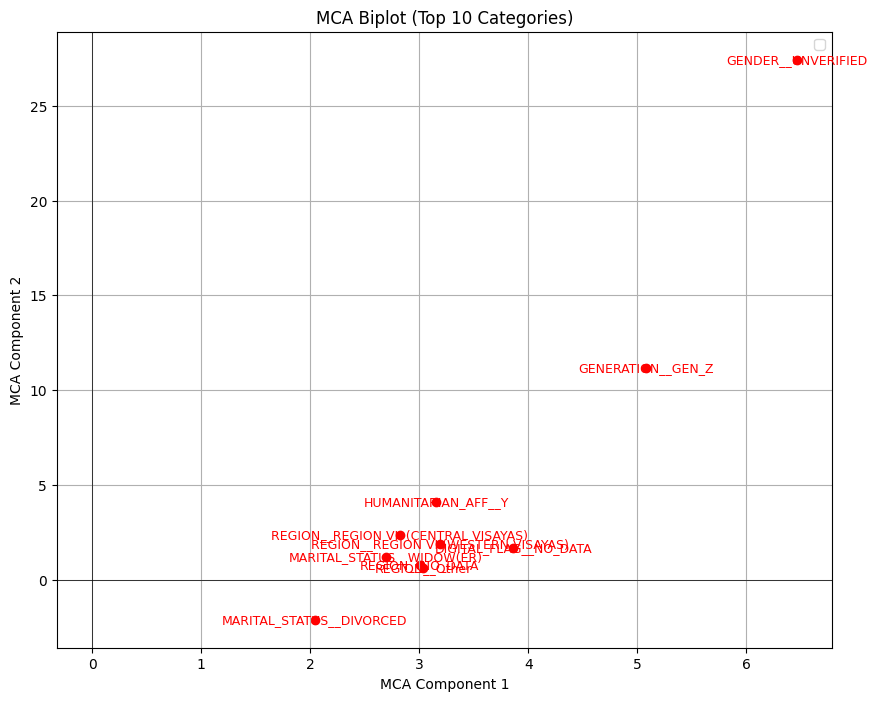

In [2434]:
category_coords = mca.column_coordinates(client_dna)

# Choose top N categories to display
N = 10 

# Compute the distance from the origin (0,0) for each category
category_coords['distance'] = np.sqrt(category_coords[0]**2 + category_coords[1]**2)

# Select the top N categories by distance
top_categories = category_coords.sort_values(by='distance', ascending=False).head(N)

plt.figure(figsize=(10, 8))

# Plot only the top N categories
for idx, row in top_categories.iterrows():
    x = row[0]
    y = row[1]
    plt.scatter(x, y, color='red')
    plt.text(x, y, idx, fontsize=9, ha='center', va='center', color='red')

plt.xlabel('MCA Component 1')
plt.ylabel('MCA Component 2')
plt.title(f'MCA Biplot (Top {N} Categories)')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()


/var/folders/0w/f3s26d1d5f1dr4pvqqxc1_140000gn/T/ipykernel_23217/562354370.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


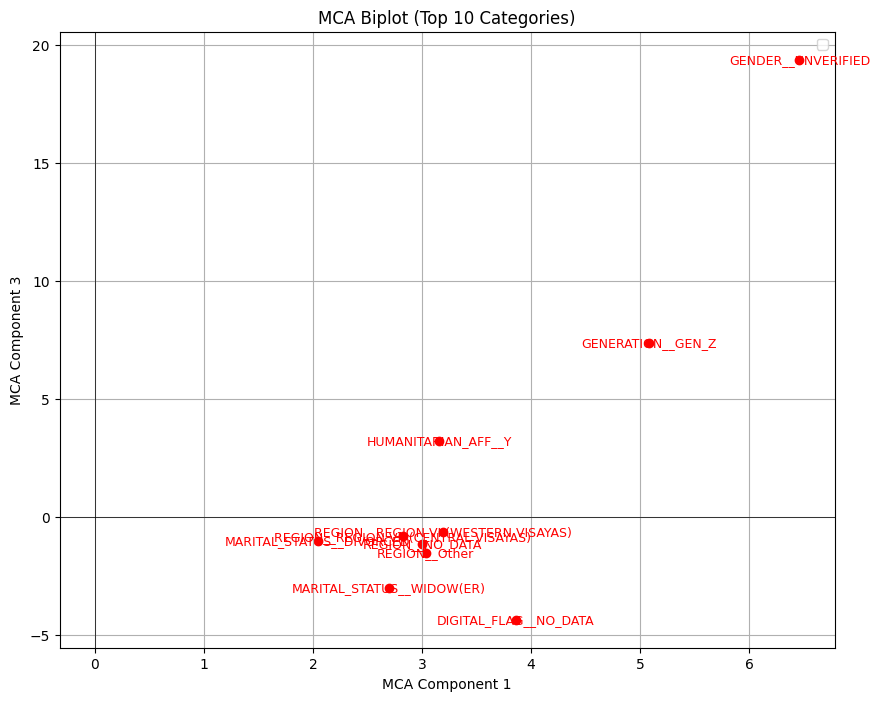

In [2435]:
category_coords = mca.column_coordinates(client_dna)

# Choose top N categories to display
N = 10 

# Compute the distance from the origin (0,0) for each category
category_coords['distance'] = np.sqrt(category_coords[0]**2 + category_coords[1]**2)

# Select the top N categories by distance
top_categories = category_coords.sort_values(by='distance', ascending=False).head(N)

plt.figure(figsize=(10, 8))

# Plot only the top N categories
for idx, row in top_categories.iterrows():
    x = row[0]
    y = row[2]
    plt.scatter(x, y, color='red')
    plt.text(x, y, idx, fontsize=9, ha='center', va='center', color='red')

plt.xlabel('MCA Component 1')
plt.ylabel('MCA Component 3')
plt.title(f'MCA Biplot (Top {N} Categories)')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()


/var/folders/0w/f3s26d1d5f1dr4pvqqxc1_140000gn/T/ipykernel_23217/584267115.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


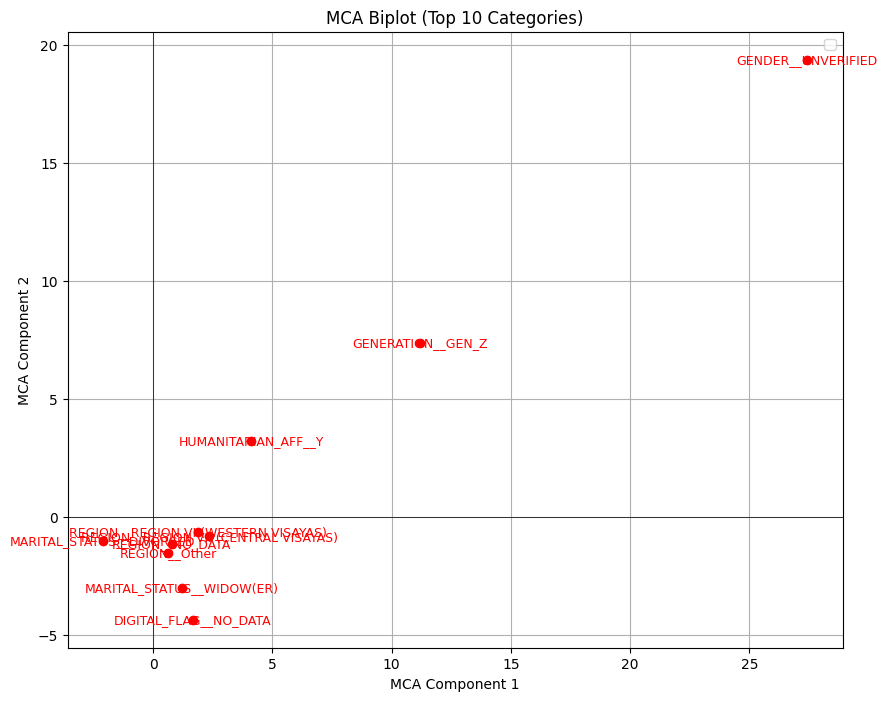

In [2436]:
category_coords = mca.column_coordinates(client_dna)

# Choose top N categories to display
N = 10 

# Compute the distance from the origin (0,0) for each category
category_coords['distance'] = np.sqrt(category_coords[0]**2 + category_coords[1]**2)

# Select the top N categories by distance
top_categories = category_coords.sort_values(by='distance', ascending=False).head(N)

plt.figure(figsize=(10, 8))

# Plot only the top N categories
for idx, row in top_categories.iterrows():
    x = row[1]
    y = row[2]
    plt.scatter(x, y, color='red')
    plt.text(x, y, idx, fontsize=9, ha='center', va='center', color='red')

plt.xlabel('MCA Component 1')
plt.ylabel('MCA Component 2')
plt.title(f'MCA Biplot (Top {N} Categories)')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.legend()
plt.grid(True)
plt.show()


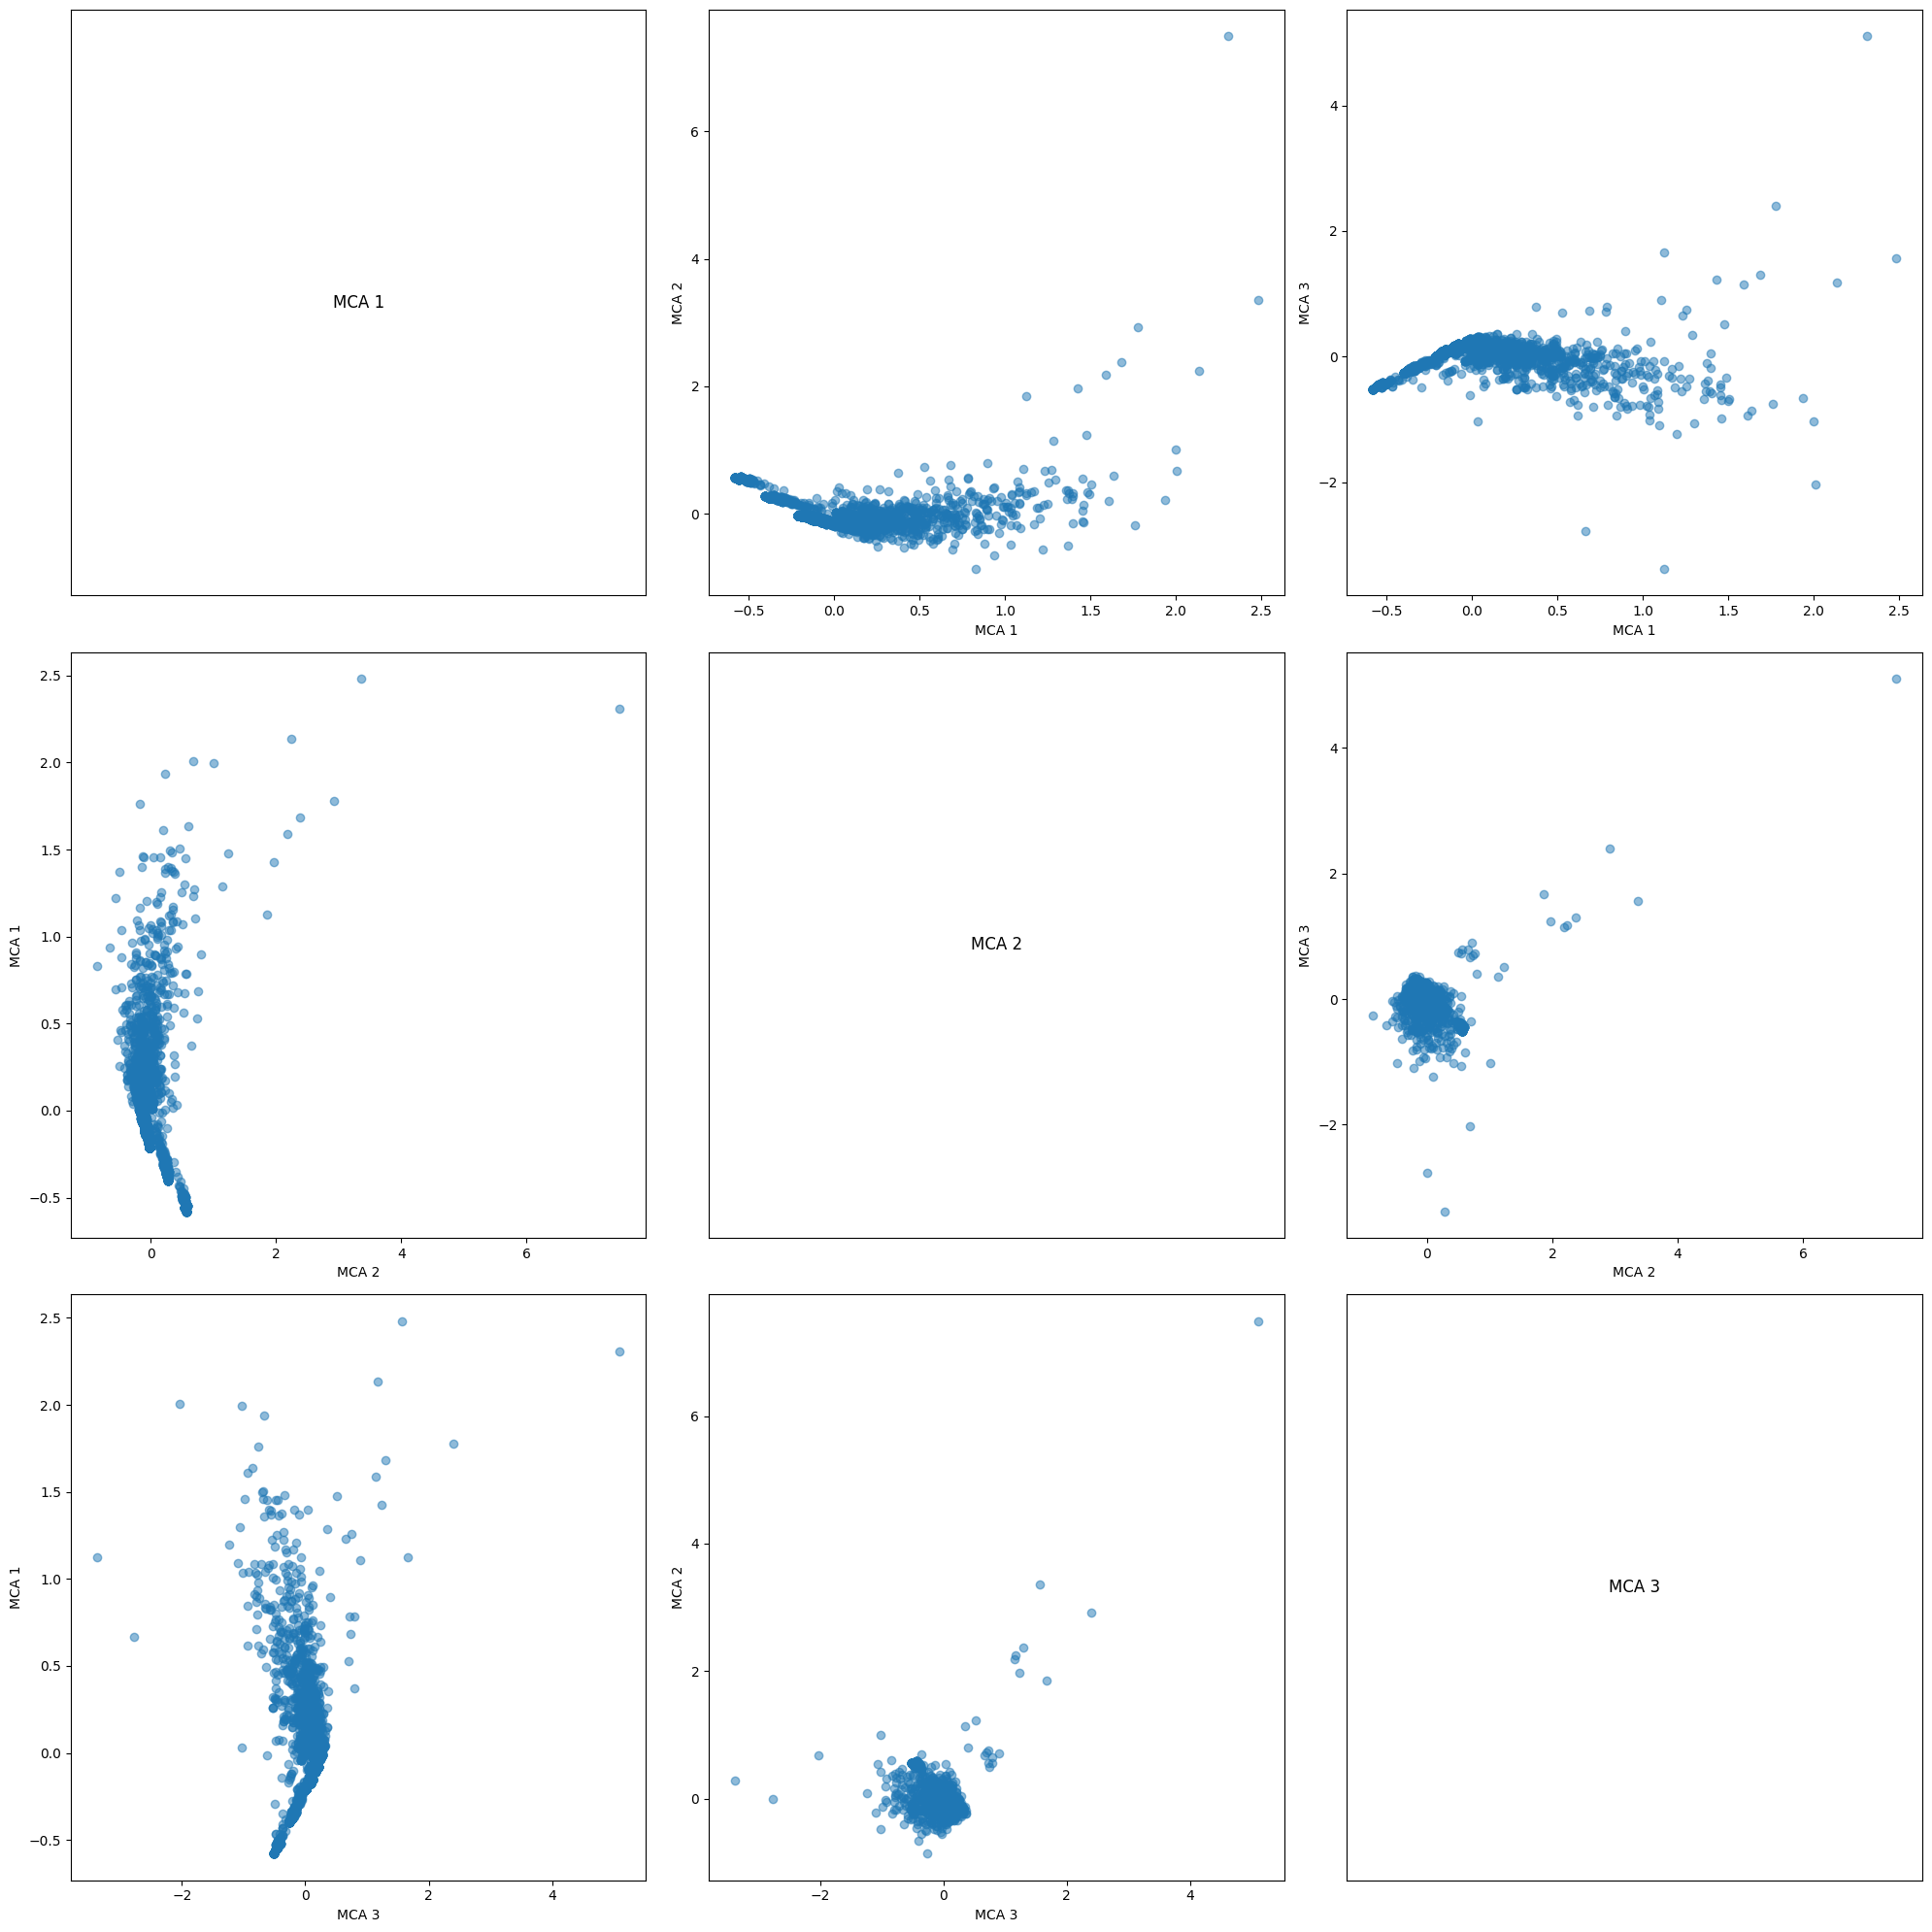

In [2437]:
n_mca = mca_df.shape[1]

# Create a figure with subplots (n_components x n_components grid)
fig, axes = plt.subplots(n_mca, n_mca, figsize=(20, 20))

for i in range(n_mca):
    for j in range(n_mca):
        ax = axes[i, j]

        if i != j:
            ax.scatter(mca_df.iloc[:, i], mca_df.iloc[:, j], alpha=0.5)
            ax.set_xlabel(f'MCA {i+1}')
            ax.set_ylabel(f'MCA {j+1}')
        else:
            ax.text(0.5, 0.5, f'MCA {i+1}', horizontalalignment='center', verticalalignment='center', fontsize=12, color='black')
            ax.set_xticks([])
            ax.set_yticks([])
plt.tight_layout()
plt.show()

##### Top 10 Variable Contributions per Component

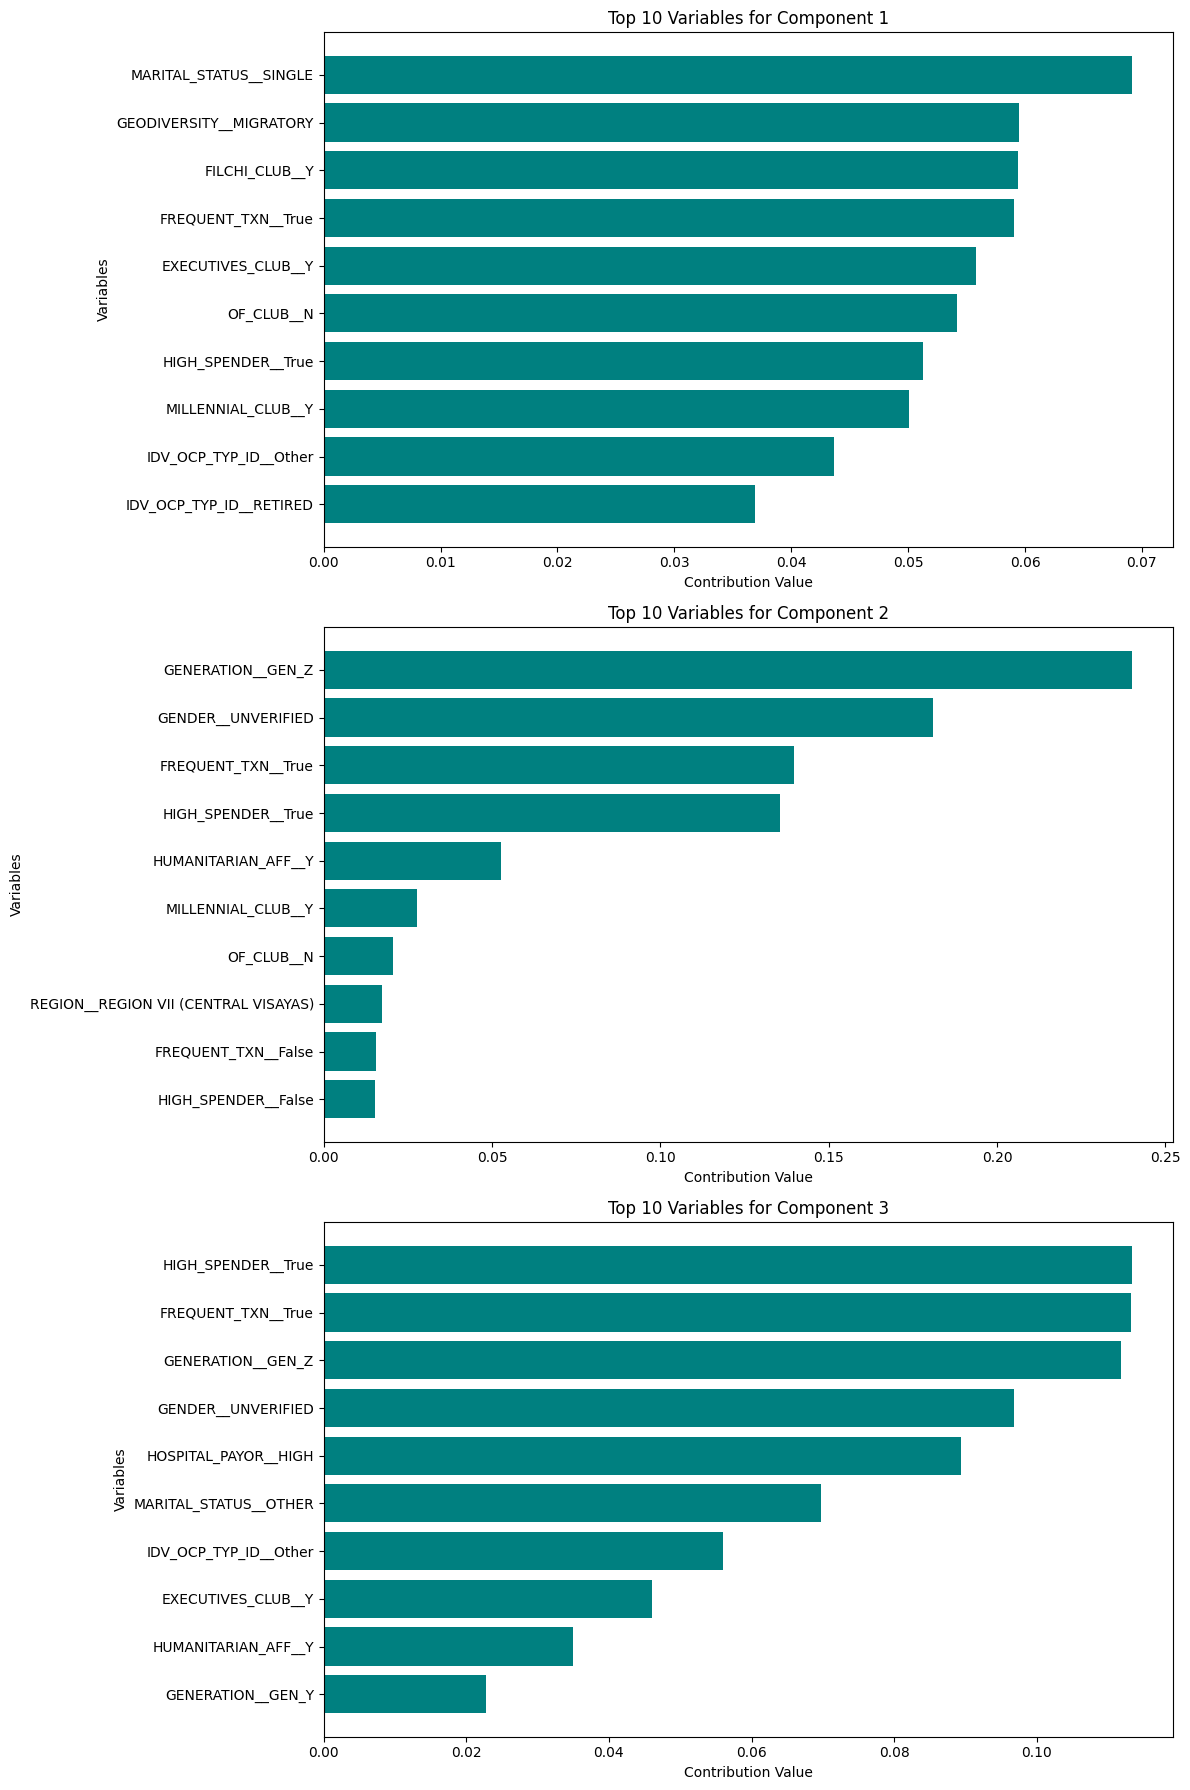

In [2438]:
variable_contributions = mca.column_contributions_
top_n = 10
fig, axes = plt.subplots(nrows=mca.n_components, figsize=(12, 6 * mca.n_components))

# Iterate over each principal component to plot the top variables
for i in range(mca.n_components):
    sorted_contribs = variable_contributions.iloc[:, i].abs().sort_values(ascending=False)
    top_variables = sorted_contribs.head(top_n)
    axes[i].barh(top_variables.index, top_variables.values, color='teal')
    axes[i].set_title(f'Top {top_n} Variables for Component {i + 1}')
    axes[i].set_xlabel('Contribution Value')
    axes[i].set_ylabel('Variables')
    axes[i].invert_yaxis() 

plt.tight_layout()
plt.show()

#### KMeans Clustering

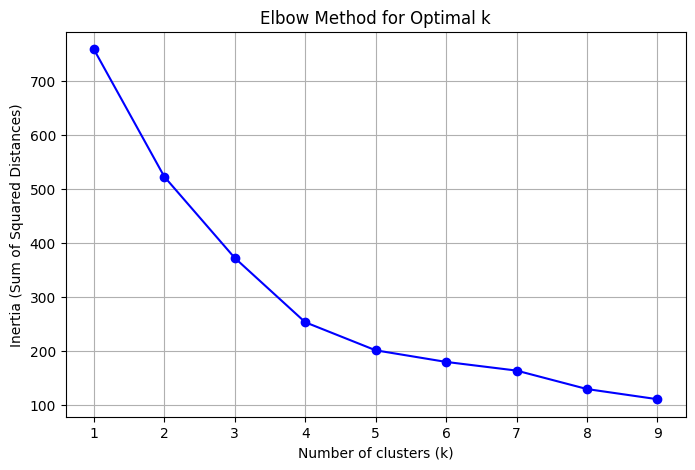

In [ ]:
#Getting the optimal k
# Elbow method setup
inertia = []
K = range(1, 10)  # Try k from 1 to 15

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(mca_df)
    inertia.append(kmeans.inertia_)

# Plot the Elbow graph
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Method for Optimal k')
plt.grid()
plt.show()

In [ ]:
# Perform KMeans
kmeans = KMeans(n_clusters=4, random_state=42) 

clusters = kmeans.fit_predict(mca_df)

# Add cluster labels to the MCA results
mca_df['Cluster'] = clusters

print(mca_df.head())
print(mca_df['Cluster'].value_counts())

          0         1         2  Cluster
0 -0.304781  0.211750 -0.130501        0
1 -0.071607 -0.129254  0.155457        2
2  0.643826 -0.079756 -0.090897        1
3 -0.109956 -0.051344  0.160646        2
4 -0.187319 -0.042373  0.047358        2
Cluster
2    2074
0     388
1     322
3       8
Name: count, dtype: int64


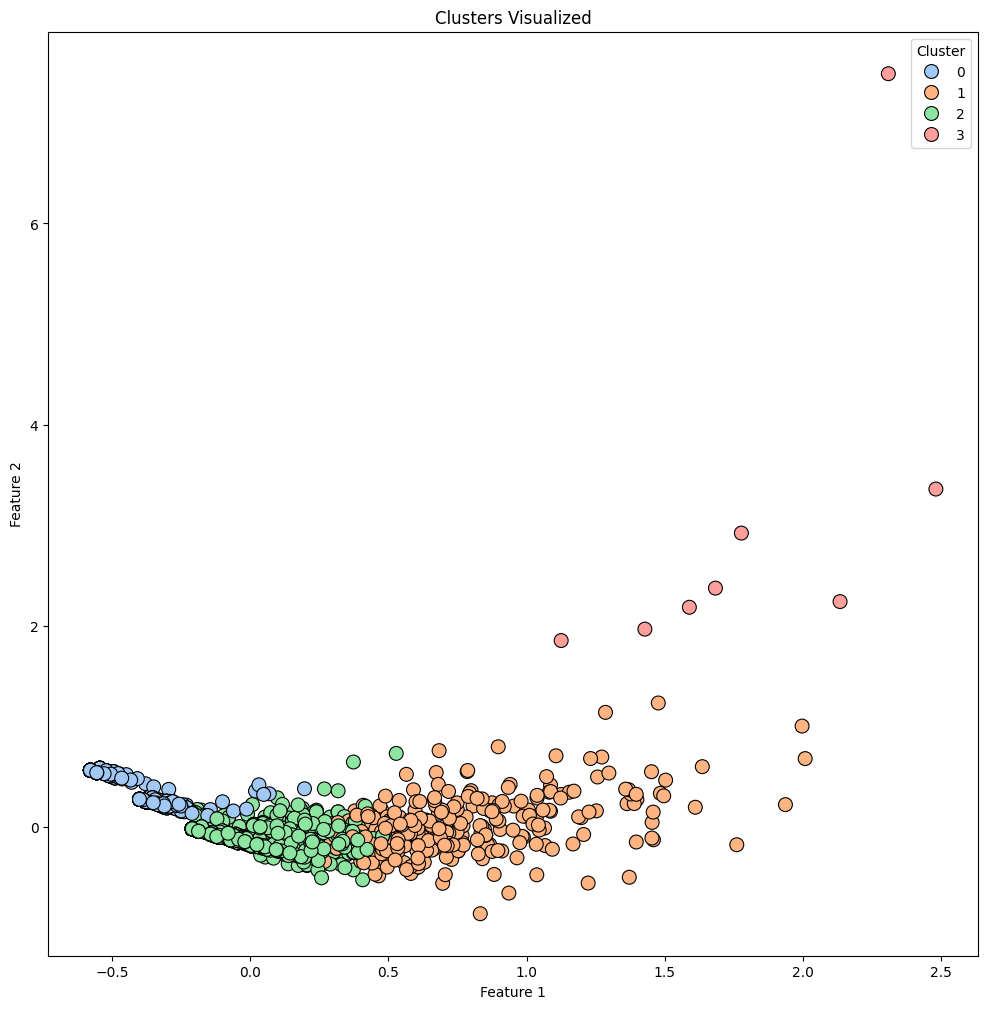

In [2441]:
# Scatterplot C1 vs C2 (CLuster)

plt.figure(figsize=(12, 12))
sns.scatterplot(x=mca_df.iloc[:, 0],
                y=mca_df.iloc[:, 1], 
                hue=mca_df['Cluster'],
                palette='pastel', 
                s=100, edgecolor='black') 
plt.title("Clusters Visualized")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster")
plt.show()

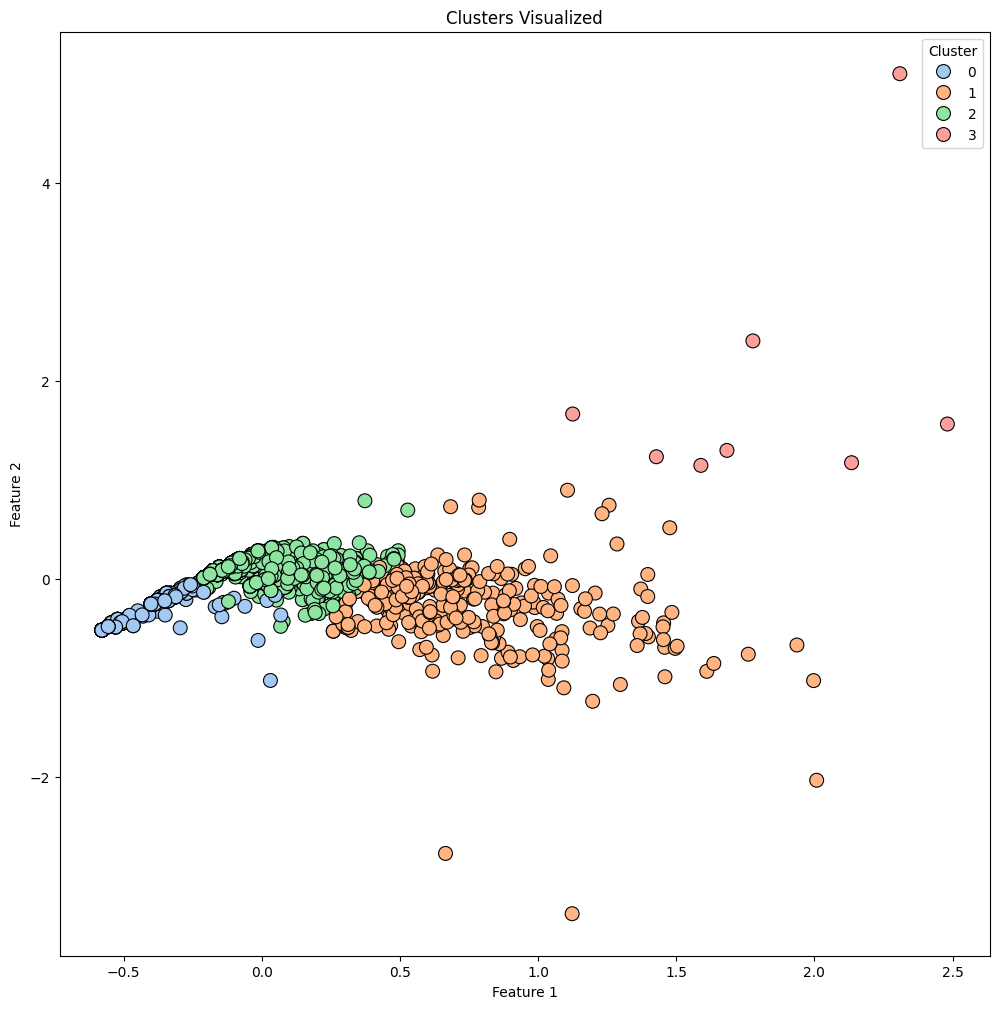

In [2442]:
# Scatterplot C1 vs C3 (CLuster)

plt.figure(figsize=(12, 12))
sns.scatterplot(x=mca_df.iloc[:, 0],
                y=mca_df.iloc[:, 2], 
                hue=mca_df['Cluster'],
                palette='pastel', 
                s=100, edgecolor='black') 
plt.title("Clusters Visualized")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster")
plt.show()

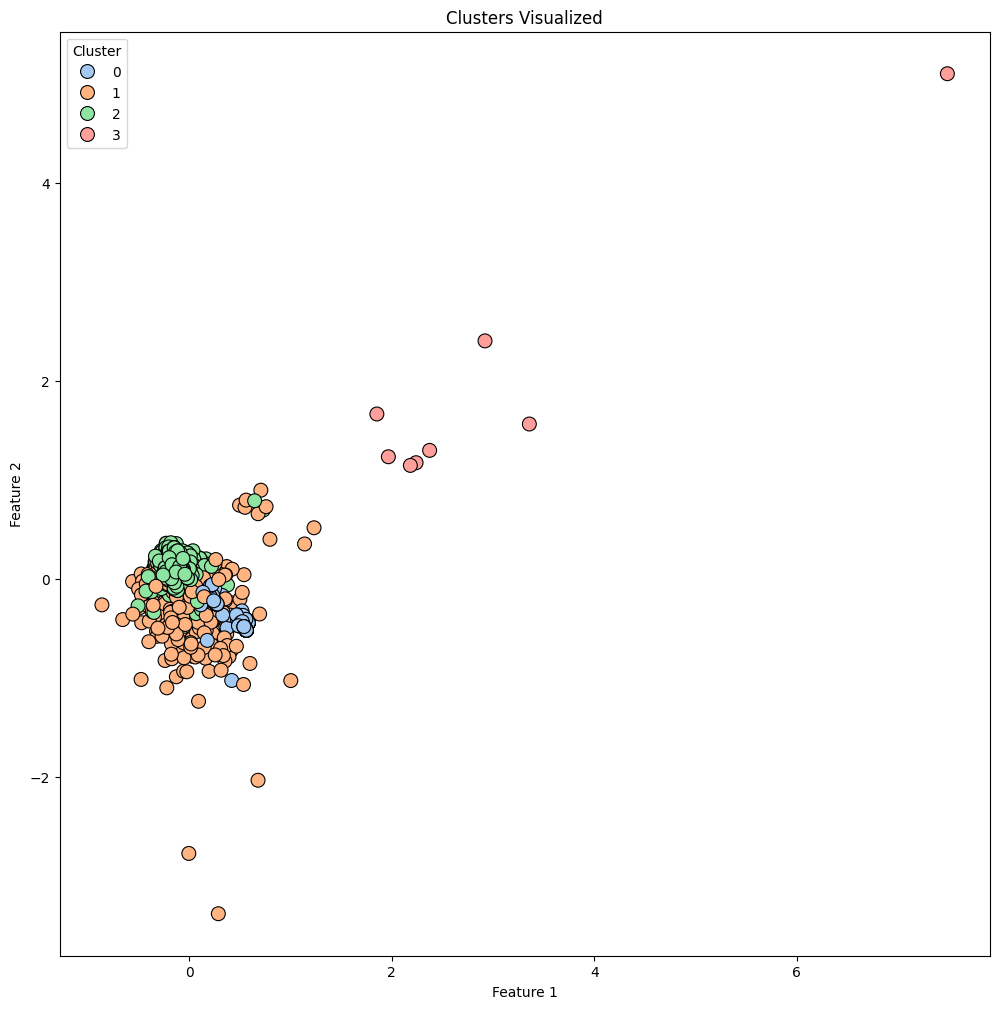

In [2443]:
# Scatterplot C2 vs C3 (CLuster)

plt.figure(figsize=(12, 12))
sns.scatterplot(x=mca_df.iloc[:, 1],
                y=mca_df.iloc[:, 2], 
                hue=mca_df['Cluster'],
                palette='pastel', 
                s=100, edgecolor='black') 
plt.title("Clusters Visualized")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(title="Cluster")
plt.show()

From the scatterplots, it can be observed that only Components 1 & 2 show clear clustering of datapoints

In [2444]:
clustered_data = pd.concat([mca_df, client_dna], axis=1)

# Find the most common values (or categories) for each cluster
cluster_attributes = clustered_data.groupby('Cluster').agg(lambda x: x.mode()[0])
cluster_attributes

,0,1,2,IDV_OCP_TYP_ID,GENERATION,GENDER,MARITAL_STATUS,DIGITAL_FLAG,TRAVELLER,GEODIVERSITY,...,HUMANITARIAN_AFF,RELIGIOUS_AFF,FILCHI_CLUB,OF_CLUB,RETIREES_CLUB,MILLENNIAL_CLUB,EXECUTIVES_CLUB,PROFESSIONAL_CLUB,HIGH_SPENDER,FREQUENT_TXN
Cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.578528,0.564178,-0.516972,EMPLOYED,BOOMERS,MALE,MARRIED,DIGITAL,HIGH,DIVERSE,...,N,N,N,Y,N,N,N,N,True,True
1,0.258873,-0.175560,-0.526606,EMPLOYED,BOOMERS,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,...,N,N,N,Y,N,N,N,N,False,False
2,-0.187319,-0.042373,0.047358,EMPLOYED,BOOMERS,FEMALE,MARRIED,DIGITAL,HIGH,DIVERSE,...,N,N,N,Y,N,N,N,N,False,False
3,1.125233,1.853276,1.146224,EMPLOYED,GEN_Z,FEMALE,MARRIED,DIGITAL,NO_DATA,MIGRATORY,...,N,N,Y,Y,N,N,N,N,False,False


Looking at cluster_attributes, it can be observed that the first 3 clusters share almost all values for each categories. Differences in valus are only present in the following variables/categories: HIGH_SPENDER, FREQUENT_TXN, GENDER. On the other hand, cluster 4 has various categories that are not the same as those in the first 3. Interestingly, cluster 4 contains outlier data points, as shown in the scatterplots.

++ If k=3 is used, cluster 4 merges into cluster 3